In [1]:
import numpy as np
import matplotlib.pyplot as plt

1 训练数据的生成

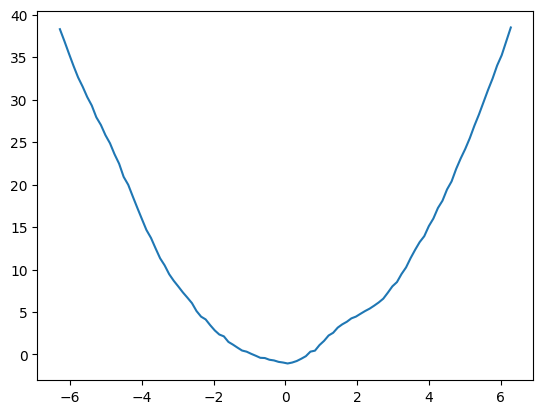

In [2]:
#  显示带噪声的曲线
sin_x = np.linspace(-2*np.pi, 2*np.pi, 100)
sin_x_squared = sin_x ** 2

sin_y = np.sin(sin_x) ** 3 + sin_x_squared.astype(np.float32) - np.cos(sin_x) ** 2 + 0.1 * np.random.randn(len(sin_x))# 使用随机数在sin函数中添加噪声

plt.plot(sin_x, sin_y)
plt.show()

In [3]:
len(sin_x)

100

2 数据的预处理

In [4]:
n_time = 10  # 时间序列的数量
n_time = 10  # 时间序列的数量
n_in = 1  # 输入层的神经元数量
n_mid = 20  # 中间层的神经元数量
n_out = 1  # 输出层的神经元数量

n_sample = len(sin_x)-n_time  # 样本数量，n_time时间序列数据的数量
print(n_sample)

input_data = np.zeros((n_sample, n_time, n_in))  # 输入40个10行1列的数据
correct_data = np.zeros((n_sample, n_out))  # 正确答案

for i in range(0, n_sample):
    input_data[i] = sin_y[i:i+n_time].reshape(-1, 1)
    correct_data[i] = sin_y[i+n_time:i+n_time+1]  ## 正确答案位于输入之后的一位


90


In [5]:
np.shape(input_data) 

(90, 10, 1)

In [6]:
np.shape(correct_data)

(90, 1)

In [7]:
 input_data

array([[[38.30544746],
        [36.89057434],
        [35.41229797],
        [33.97337857],
        [32.62215212],
        [31.53558541],
        [30.31752709],
        [29.3152766 ],
        [27.9309094 ],
        [27.02856768]],

       [[36.89057434],
        [35.41229797],
        [33.97337857],
        [32.62215212],
        [31.53558541],
        [30.31752709],
        [29.3152766 ],
        [27.9309094 ],
        [27.02856768],
        [25.82582372]],

       [[35.41229797],
        [33.97337857],
        [32.62215212],
        [31.53558541],
        [30.31752709],
        [29.3152766 ],
        [27.9309094 ],
        [27.02856768],
        [25.82582372],
        [24.86826976]],

       [[33.97337857],
        [32.62215212],
        [31.53558541],
        [30.31752709],
        [29.3152766 ],
        [27.9309094 ],
        [27.02856768],
        [25.82582372],
        [24.86826976],
        [23.57480028]],

       [[32.62215212],
        [31.53558541],
        [30.31752709],
   

In [8]:
 correct_data

array([[25.82582372],
       [24.86826976],
       [23.57480028],
       [22.46761301],
       [20.9122622 ],
       [19.98479391],
       [18.60824234],
       [17.26291611],
       [15.95362042],
       [14.65741147],
       [13.72107113],
       [12.50179024],
       [11.32568883],
       [10.48874529],
       [ 9.44445967],
       [ 8.6725934 ],
       [ 8.00140641],
       [ 7.30559909],
       [ 6.68245104],
       [ 6.03939405],
       [ 5.10550773],
       [ 4.44969685],
       [ 4.12422443],
       [ 3.44589399],
       [ 2.83014948],
       [ 2.345242  ],
       [ 2.12793092],
       [ 1.47233225],
       [ 1.15253997],
       [ 0.79668875],
       [ 0.45750655],
       [ 0.32300753],
       [ 0.07135247],
       [-0.15625306],
       [-0.39804765],
       [-0.4261908 ],
       [-0.62680196],
       [-0.70717067],
       [-0.87537189],
       [-0.95466419],
       [-1.06682276],
       [-0.95649301],
       [-0.77741293],
       [-0.50872176],
       [-0.20926842],
       [ 0

3 RNN网络类
其中包含了前向和反向传播算法，并且包含了梯度清零和优化

In [9]:
# -- RNN网络层  -- 
class SimpleRNNLayer:
    def __init__(self, n_upper, n):
        # 参数的初始值
        self.w = np.random.randn(n_upper, n) / np.sqrt(n_upper)  # Xavier的初始值
        self.v = np.random.randn(n, n) / np.sqrt(n)  # Xavier的初始值
        self.b = np.zeros(n)

    def forward(self, x, y_prev): # y_prev: 前一时刻的输出
        u = np.dot(x, self.w) + np.dot(y_prev, self.v) + self.b
        self.y = np.tanh(u)  # 输出
    
    def backward(self, x, y, y_prev, grad_y):
        delta = grad_y * (1 - y**2)

        # 各个梯度
        self.grad_w += np.dot(x.T, delta)
        self.grad_v += np.dot(y_prev.T, delta)
        self.grad_b += np.sum(delta, axis=0)

        self.grad_x = np.dot(delta, self.w.T)
        self.grad_y_prev = np.dot(delta, self.v.T)

    def reset_sum_grad(self):
        self.grad_w = np.zeros_like(self.w)
        self.grad_v = np.zeros_like(self.v)
        self.grad_b = np.zeros_like(self.b)

    def update(self, eta):
        self.w -= eta * self.grad_w
        self.v -= eta * self.grad_v
        self.b -= eta * self.grad_b

3 输出层 
  接收隐藏层传递过来的数据，并激活输出

In [10]:
# -- 全连接输出层 --
class OutputLayer:
    def __init__(self, n_upper, n):
        self.w = np.random.randn(n_upper, n) / np.sqrt(n_upper)  # # Xavier的初始值
        self.b = np.zeros(n)

    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = u  # 恒等函数

    def backward(self, t):
        delta = self.y - t
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T) 

    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b

4 训练函数train
  
  1 正向传播时输出的y传向后面的时刻。反向传播传递的是grad_y,传向前面的时刻。
  2 y_rnn存储了正向传播的数据原因grad_w依赖当前时刻y和前面时刻的y_prev.

In [11]:
# -- 训练 --
def train(x_mb, t_mb):
    # 正向传播 RNN网络层
    y_rnn = np.zeros((len(x_mb), n_time+1, n_mid))
    y_prev = y_rnn[:, 0, :]
    for i in range(n_time):
        x = x_mb[:, i, :]
        rnn_layer.forward(x, y_prev)
        y = rnn_layer.y
        y_rnn[:, i+1, :] = y   # 当前时刻的y
        y_prev = y             #存储成下一时刻y_prev

    # 正向传播 输出层
    output_layer.forward(y)

    # 反向传播 输出层
    output_layer.backward(t_mb)
    grad_y = output_layer.grad_x

    # 反向传播 RNN层
    rnn_layer.reset_sum_grad()
    for i in reversed(range(n_time)):
        x = x_mb[:, i, :]
        y = y_rnn[:, i+1, :]
        y_prev = y_rnn[:, i, :]
        rnn_layer.backward(x, y, y_prev, grad_y)
        grad_y = rnn_layer.grad_y_prev

    # 参数的更新
    rnn_layer.update(eta)
    output_layer.update(eta)

In [12]:
# -- 各项设置参数 --
n_time = 10  # 时间序列的数量
n_in = 1  # 输入层的神经元数量
n_mid = 20  # 中间层的神经元数量
n_out = 1  # 输出层的神经元数量

eta = 0.001  # 学习系数
epochs = 1000
batch_size = 8
interval = 5  # 显示处理进度的间隔

In [13]:
# -- 生成训练数据集 --
sin_x = np.linspace(-2*np.pi, 2*np.pi, 100)
sin_x_squared = sin_x ** 2

sin_y = np.sin(sin_x) ** 3 + sin_x_squared.astype(np.float32) - np.cos(sin_x) ** 2 + 0.1 * np.random.randn(len(sin_x))# 使用随机数在sin函数中添加噪声

n_sample = len(sin_x)-n_time  # 样本数量

print(n_sample)

input_data = np.zeros((n_sample, n_time, n_in))  # 输入 40个10行1列的数据

correct_data = np.zeros((n_sample, n_out))  # 正确答案

for i in range(0, n_sample):
    input_data[i] = sin_y[i:i+n_time].reshape(-1, 1)
    correct_data[i] = sin_y[i+n_time:i+n_time+1]  ## 正确答案位于输入之后的一位

len(input_data)

#print(input_data)
#print(correct_data)
#len(correct_data)

90


90

In [14]:
# -- RNN网络层  -- 
class SimpleRNNLayer:
    def __init__(self, n_upper, n):
        # 参数的初始值
        self.w = np.random.randn(n_upper, n) / np.sqrt(n_upper)  # Xavier的初始值
        self.v = np.random.randn(n, n) / np.sqrt(n)  # Xavier的初始值
        self.b = np.zeros(n)

    def forward(self, x, y_prev): # y_prev: 前一时刻的输出
        u = np.dot(x, self.w) + np.dot(y_prev, self.v) + self.b
        self.y = np.tanh(u)  # 输出
    
    def backward(self, x, y, y_prev, grad_y):
        delta = grad_y * (1 - y**2)

        # 各个梯度
        self.grad_w += np.dot(x.T, delta)
        self.grad_v += np.dot(y_prev.T, delta)
        self.grad_b += np.sum(delta, axis=0)

        self.grad_x = np.dot(delta, self.w.T)
        self.grad_y_prev = np.dot(delta, self.v.T)

    def reset_sum_grad(self):
        self.grad_w = np.zeros_like(self.w)
        self.grad_v = np.zeros_like(self.v)
        self.grad_b = np.zeros_like(self.b)

    def update(self, eta):
        self.w -= eta * self.grad_w
        self.v -= eta * self.grad_v
        self.b -= eta * self.grad_b




In [15]:
# -- 全连接输出层 --
class OutputLayer:
    def __init__(self, n_upper, n):
        self.w = np.random.randn(n_upper, n) / np.sqrt(n_upper)  # # Xavier的初始值
        self.b = np.zeros(n)

    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = u  # 恒等函数

    def backward(self, t):
        delta = self.y - t
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T) 

    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b



In [16]:
 #−− 各个网络层的初始化 −−
rnn_layer = SimpleRNNLayer(n_in, n_mid)
output_layer = OutputLayer(n_mid, n_out)



In [17]:
# -- 训练 --
def train(x_mb, t_mb):
    # 正向传播 RNN网络层
    y_rnn = np.zeros((len(x_mb), n_time+1, n_mid))
    y_prev = y_rnn[:, 0, :]
    for i in range(n_time):
        x = x_mb[:, i, :]
        rnn_layer.forward(x, y_prev)
        y = rnn_layer.y
        y_rnn[:, i+1, :] = y
        y_prev = y

    # 正向传播 输出层
    output_layer.forward(y)

    # 反向传播 输出层
    output_layer.backward(t_mb)
    grad_y = output_layer.grad_x

    # 反向传播 RNN层
    rnn_layer.reset_sum_grad()
    for i in reversed(range(n_time)):
        x = x_mb[:, i, :]
        y = y_rnn[:, i+1, :]
        y_prev = y_rnn[:, i, :]
        rnn_layer.backward(x, y, y_prev, grad_y)
        grad_y = rnn_layer.grad_y_prev

    # 参数的更新
    rnn_layer.update(eta)
    output_layer.update(eta)

In [18]:
# -- 预测 --
def predict(x_mb):
    # 正向传播 RNN层
    y_prev = np.zeros((len(x_mb), n_mid))
    for i in range(n_time):
        x = x_mb[:, i, :]
        rnn_layer.forward(x, y_prev)
        y = rnn_layer.y
        y_prev = y

    # 正向传播 输出层
    output_layer.forward(y)
    return output_layer.y



In [19]:
# -- 誤计算误差  --
def get_error(x, t):
    y = predict(x)
    return 1.0/2.0*np.sum(np.square(y - t))  # 误差平方和



Epoch:1/1000 Error:3381.9325515806263


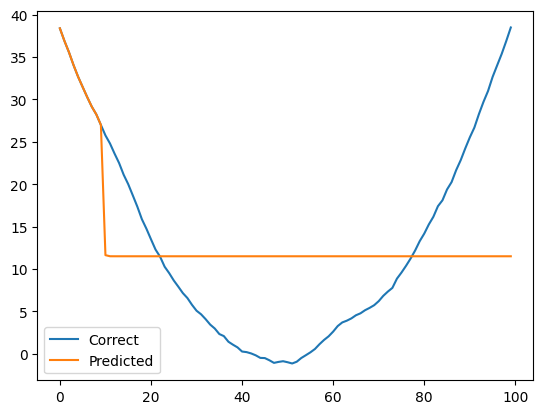

Epoch:6/1000 Error:2114.0544260647494


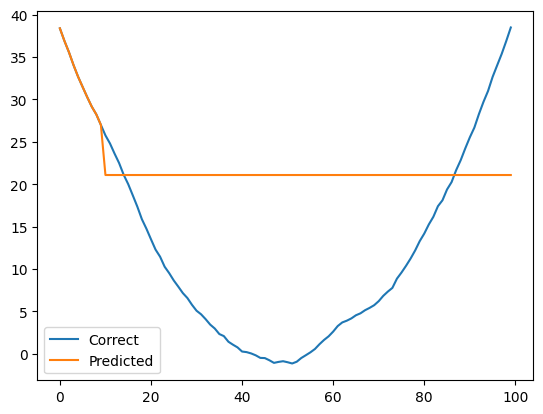

Epoch:11/1000 Error:587.3245461834715


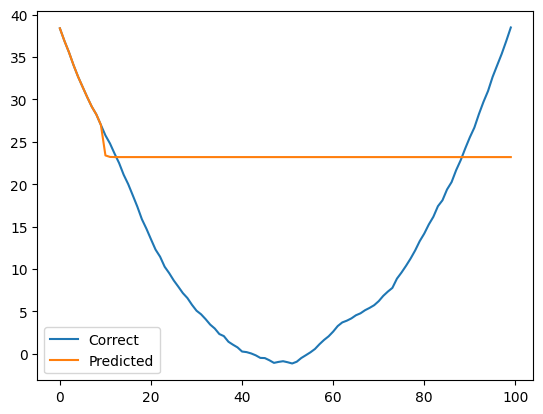

Epoch:16/1000 Error:1040.400818633256


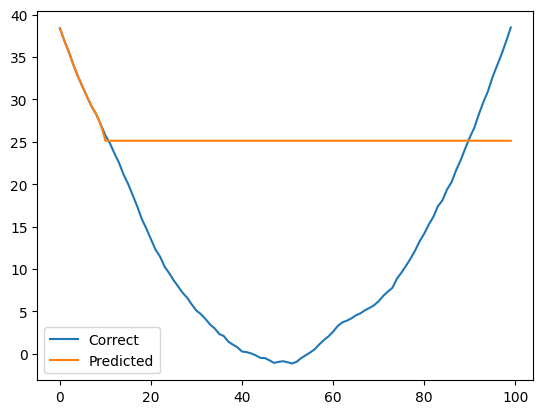

Epoch:21/1000 Error:786.9086252857835


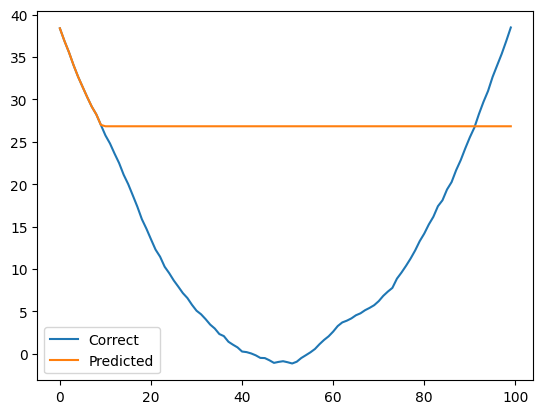

Epoch:26/1000 Error:751.3066664538878


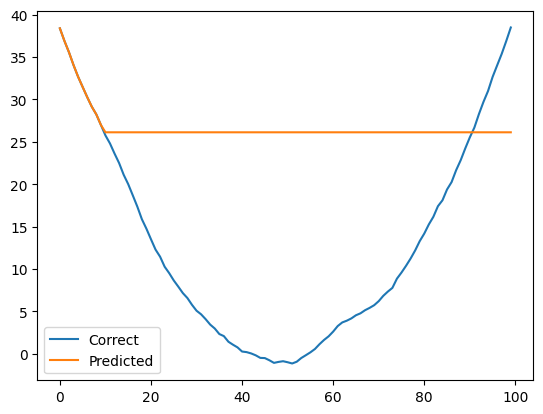

Epoch:31/1000 Error:298.4786282927987


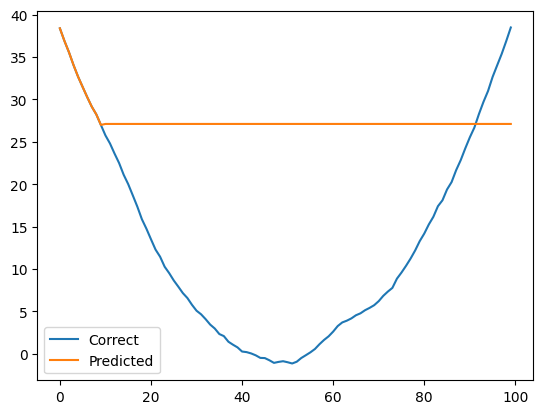

Epoch:36/1000 Error:394.2167390166466


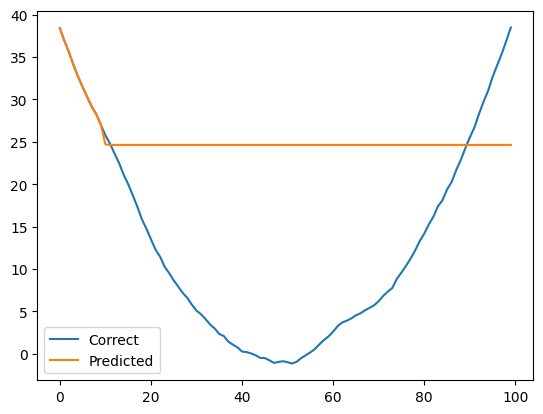

Epoch:41/1000 Error:420.2256433796681


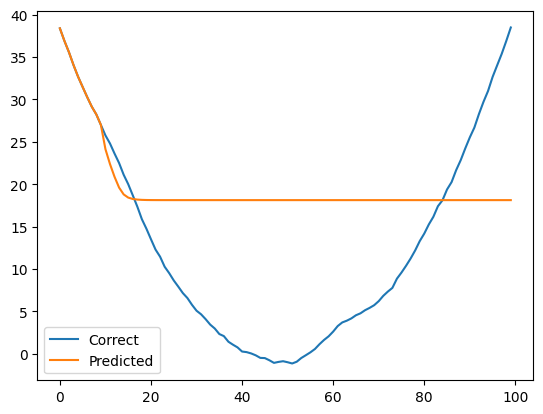

Epoch:46/1000 Error:533.2074144375379


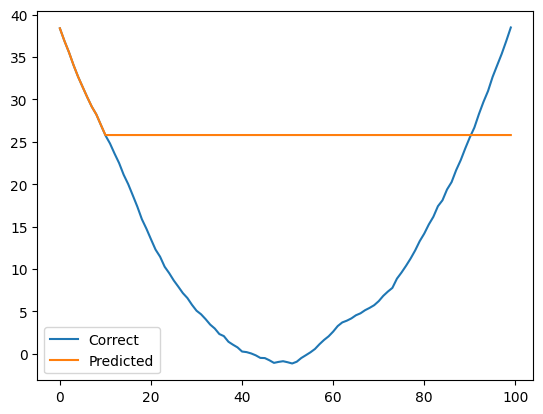

Epoch:51/1000 Error:617.118362618303


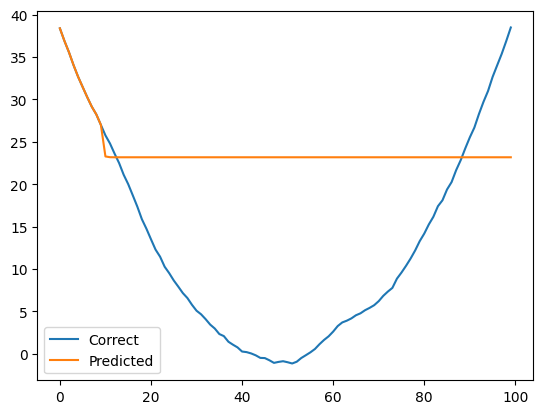

Epoch:56/1000 Error:943.3865329741593


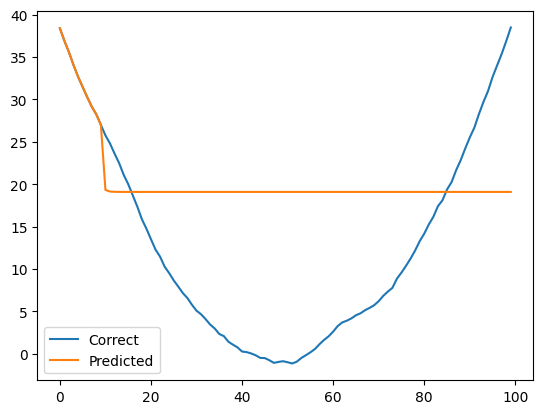

Epoch:61/1000 Error:1537.0008319552746


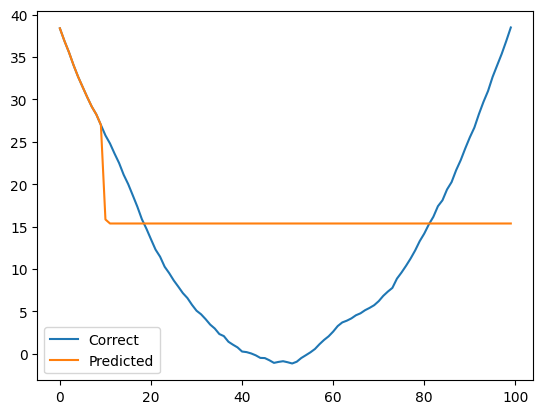

Epoch:66/1000 Error:525.8819566611102


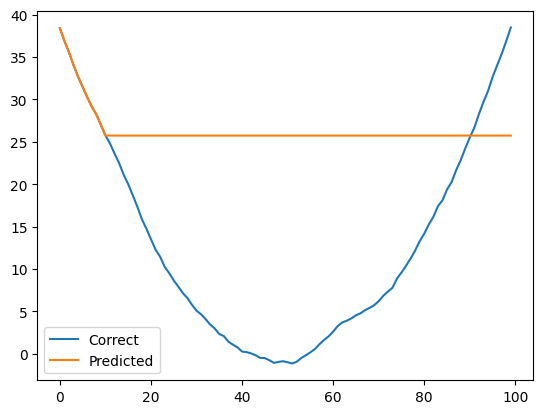

Epoch:71/1000 Error:1139.8132495507487


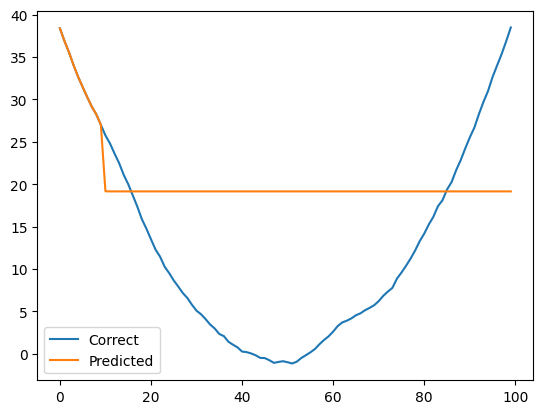

Epoch:76/1000 Error:639.4939501148046


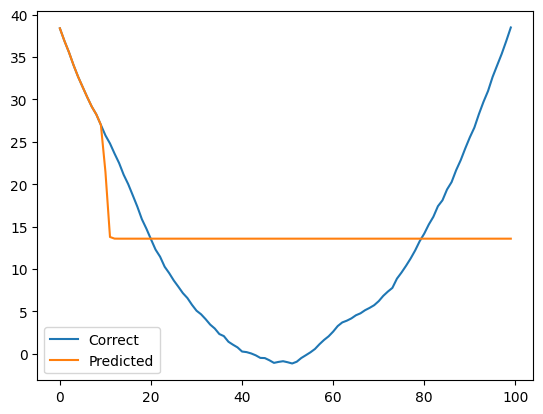

Epoch:81/1000 Error:499.24649294454866


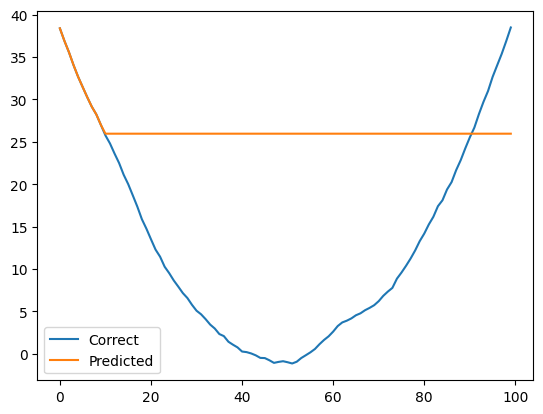

Epoch:86/1000 Error:627.9057912022638


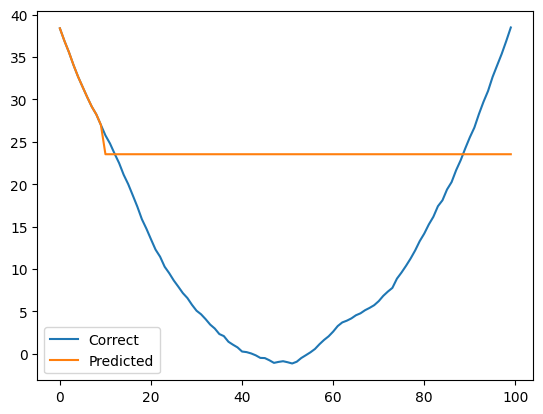

Epoch:91/1000 Error:1522.1453527388023


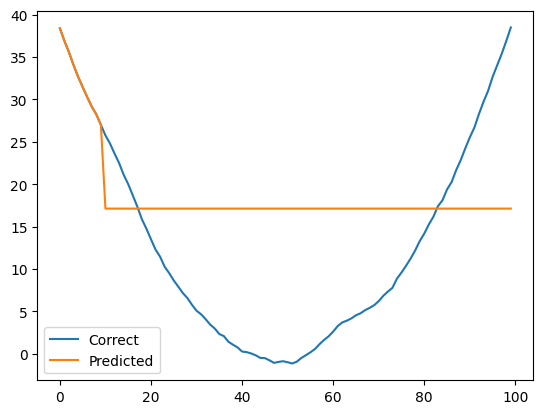

Epoch:96/1000 Error:663.2615088879952


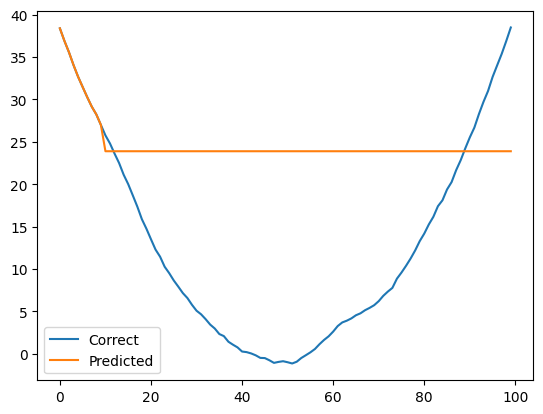

Epoch:101/1000 Error:385.2135320159458


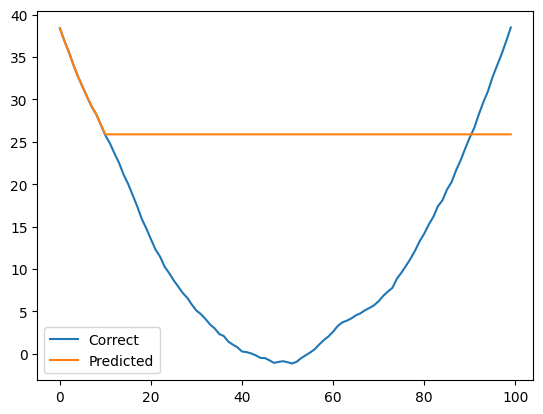

Epoch:106/1000 Error:2255.7757055381385


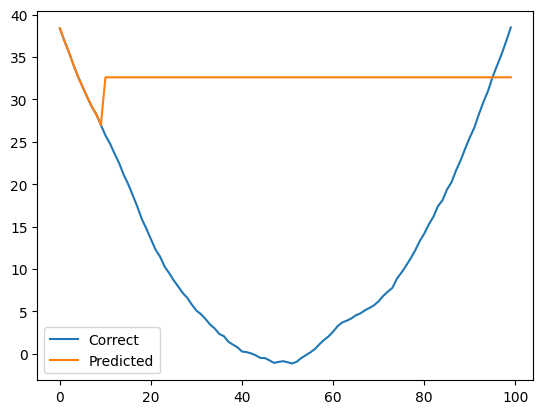

Epoch:111/1000 Error:2335.1691185853224


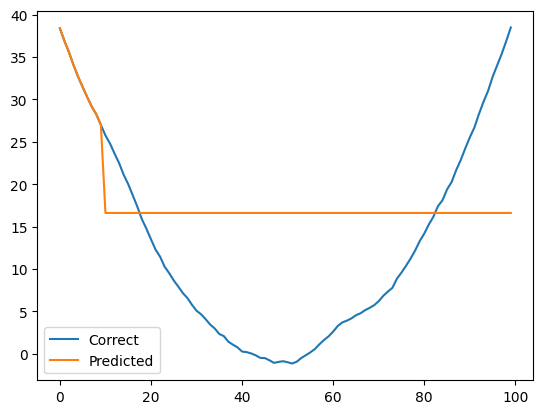

Epoch:116/1000 Error:1515.625200326714


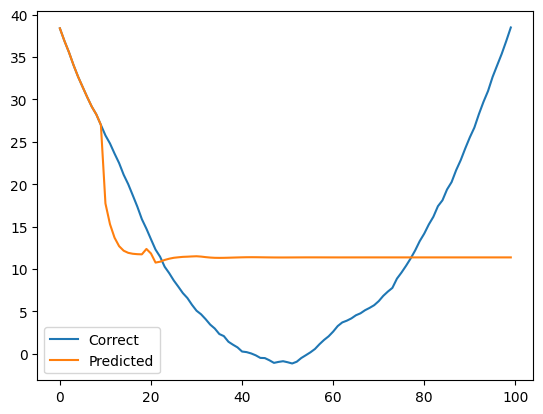

Epoch:121/1000 Error:1026.1011010537977


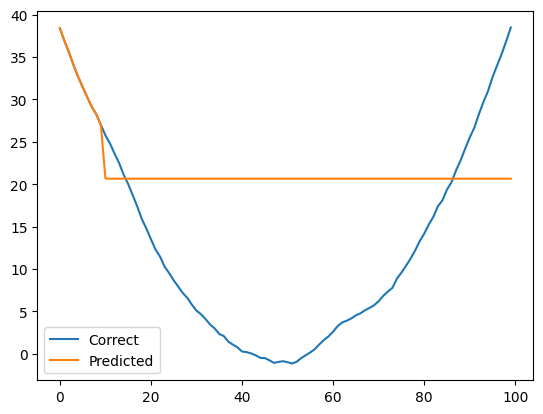

Epoch:126/1000 Error:831.5645997909916


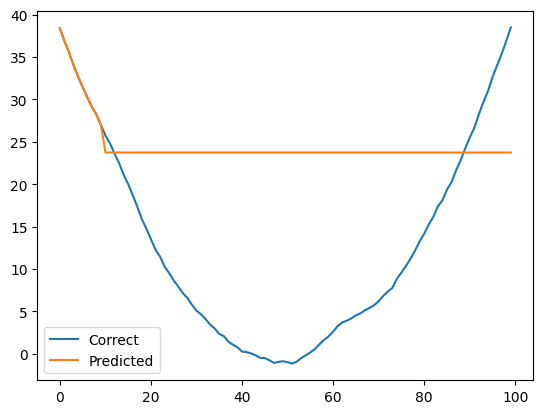

Epoch:131/1000 Error:516.1397870314539


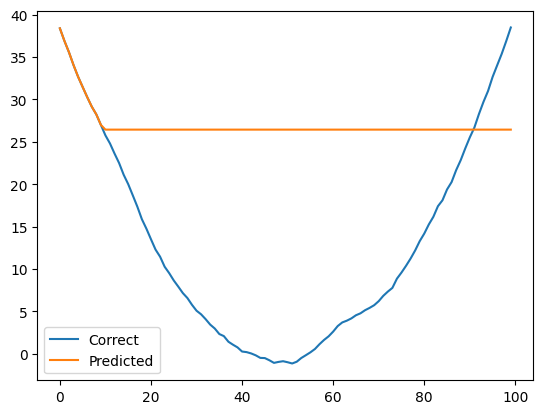

Epoch:136/1000 Error:1593.4885464163453


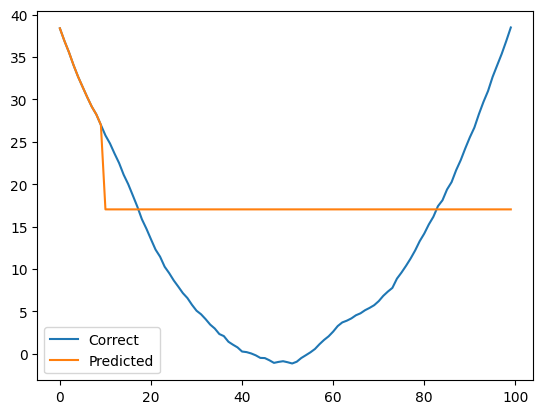

Epoch:141/1000 Error:483.12325125781507


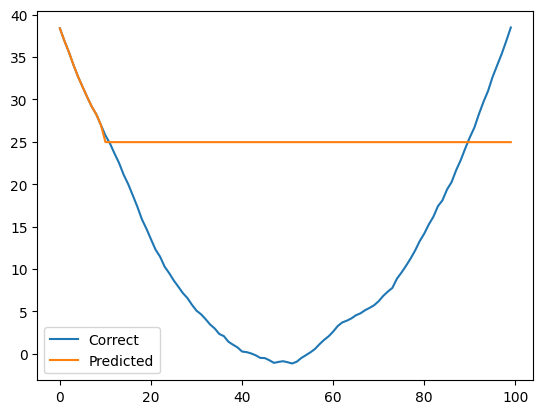

Epoch:146/1000 Error:596.2890646378463


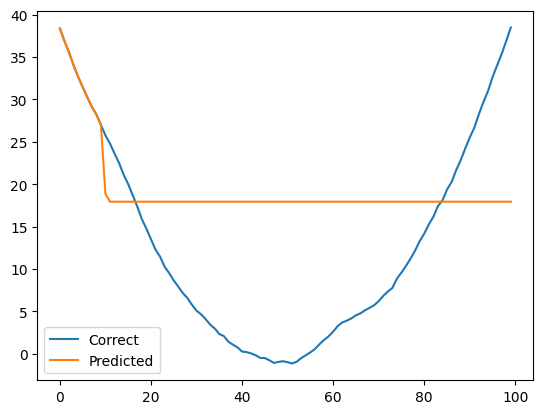

Epoch:151/1000 Error:670.8999302246373


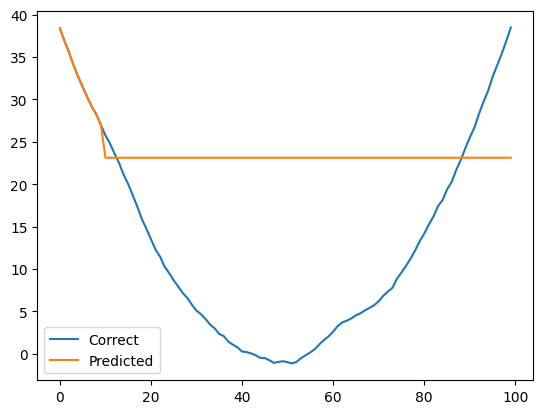

Epoch:156/1000 Error:536.4627345803622


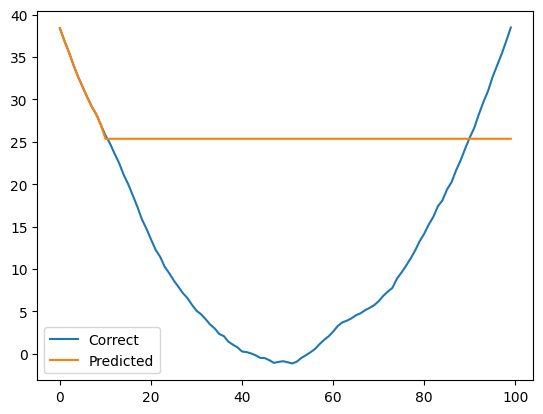

Epoch:161/1000 Error:431.8684816756113


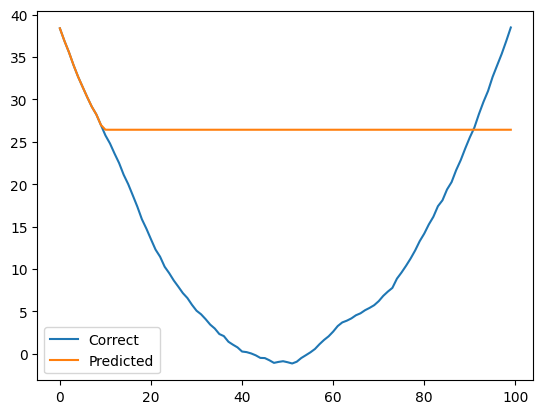

Epoch:166/1000 Error:446.09965724670474


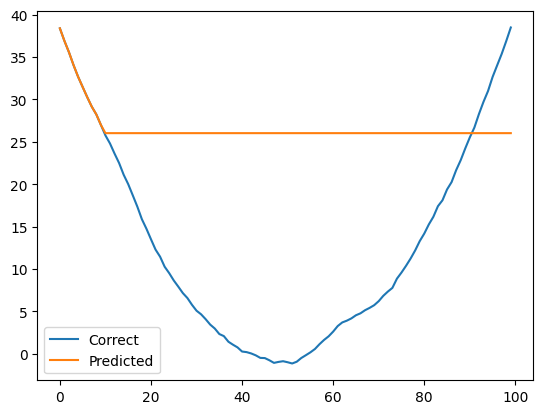

Epoch:171/1000 Error:405.5978852290146


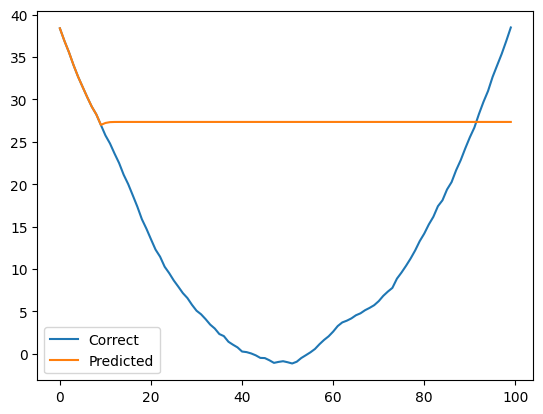

Epoch:176/1000 Error:475.7819472125357


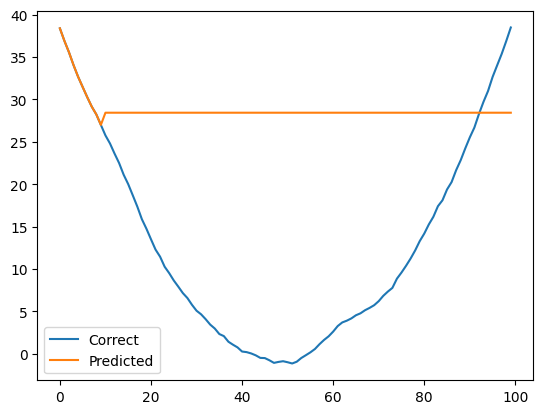

Epoch:181/1000 Error:365.1882668226233


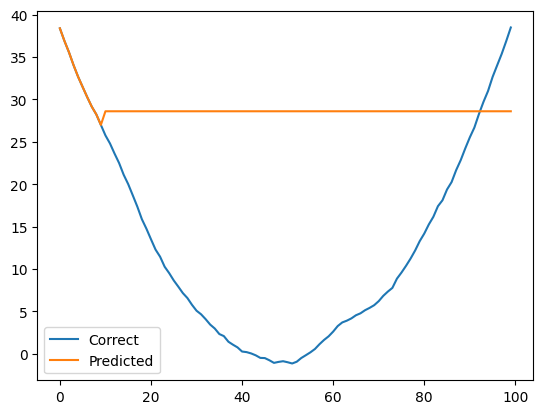

Epoch:186/1000 Error:1736.0855520353327


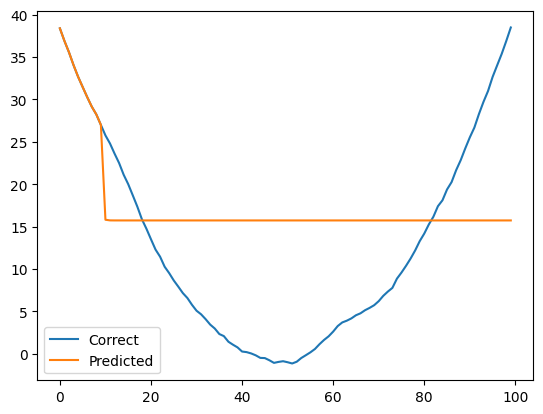

Epoch:191/1000 Error:1370.4497359275233


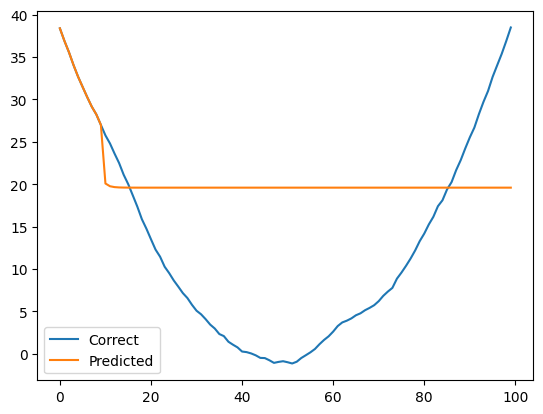

Epoch:196/1000 Error:389.8655524691431


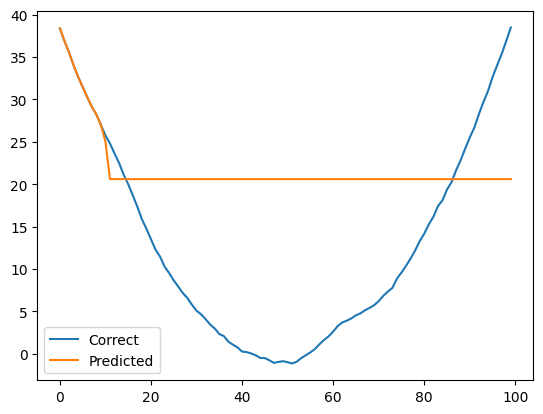

Epoch:201/1000 Error:1427.9663859163397


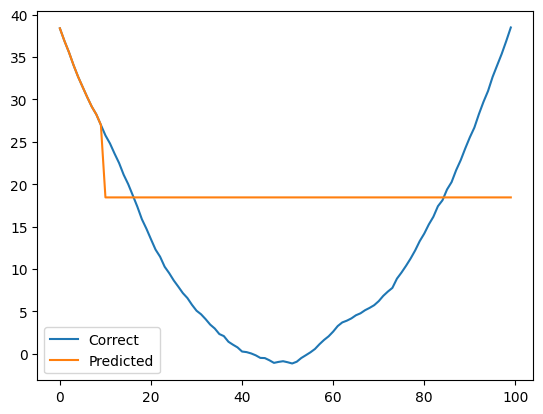

Epoch:206/1000 Error:955.6508767728059


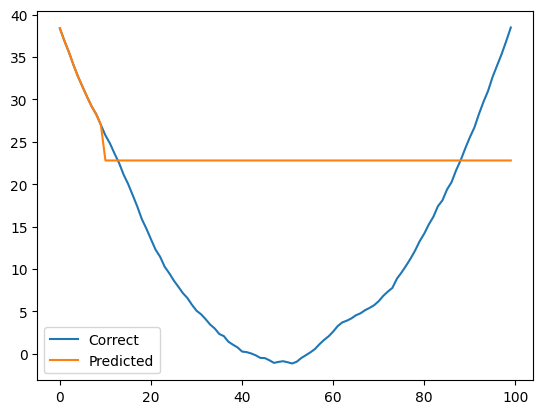

Epoch:211/1000 Error:965.1600121237071


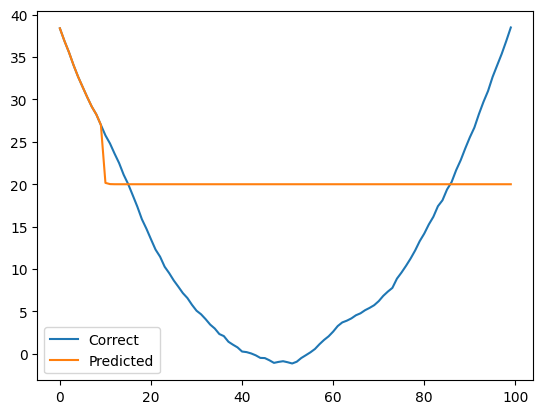

Epoch:216/1000 Error:471.29583997841337


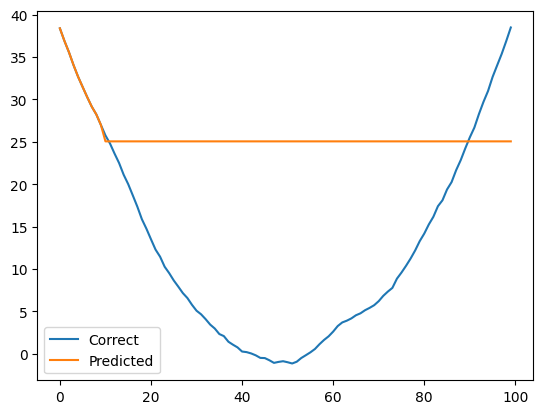

Epoch:221/1000 Error:968.5919155667568


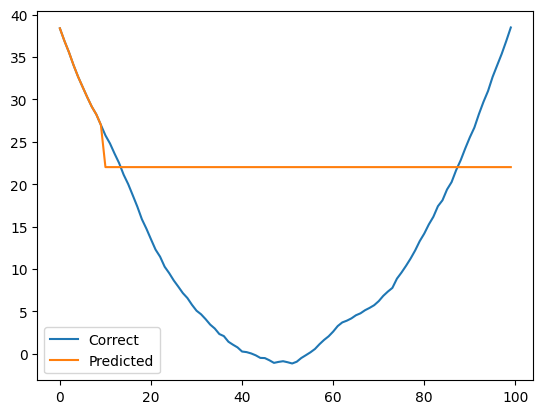

Epoch:226/1000 Error:1326.689960685935


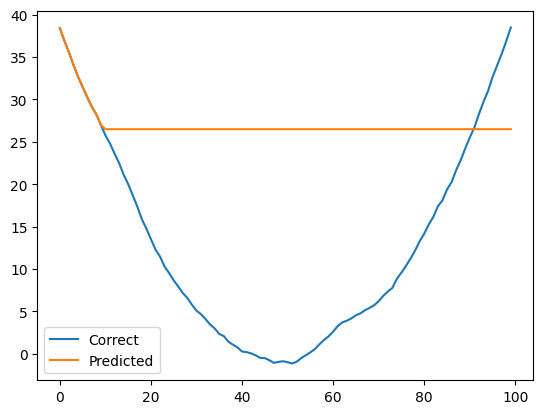

Epoch:231/1000 Error:1250.8895291952106


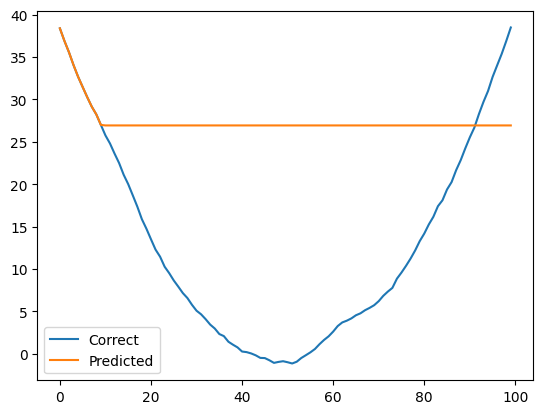

Epoch:236/1000 Error:649.152610673317


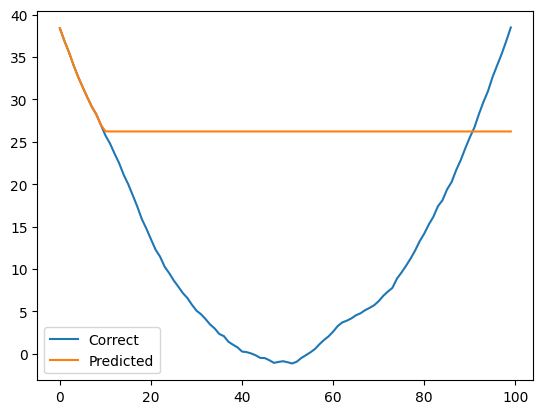

Epoch:241/1000 Error:1273.8652352775928


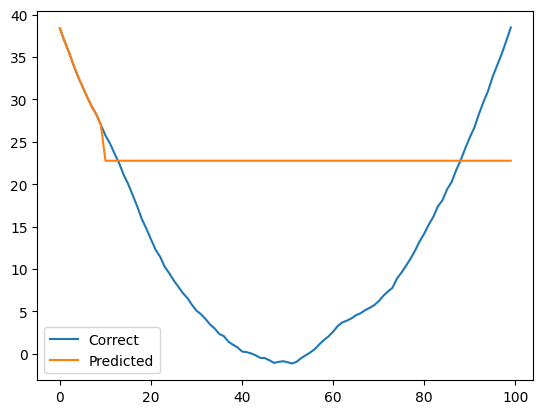

Epoch:246/1000 Error:1942.1228115675349


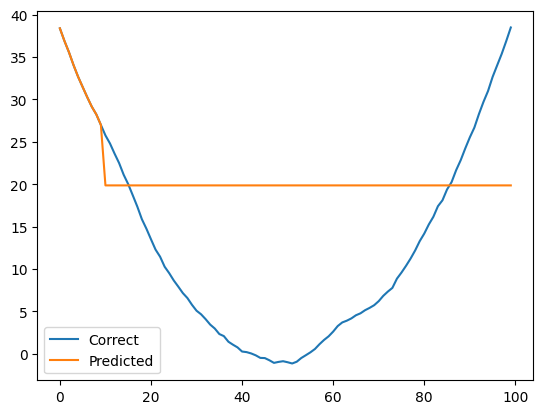

Epoch:251/1000 Error:1654.1596437476423


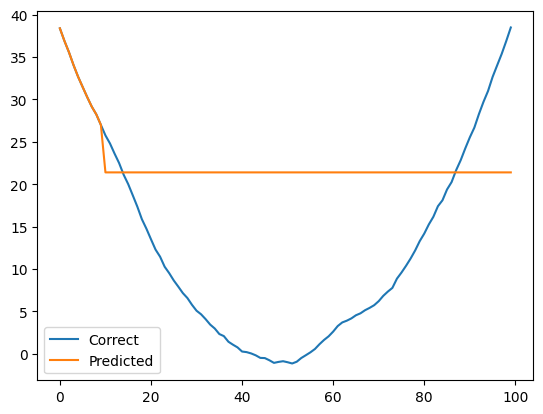

Epoch:256/1000 Error:2861.053011139061


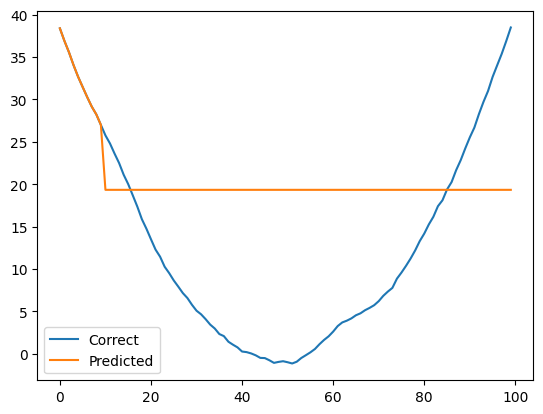

Epoch:261/1000 Error:1866.5174398068968


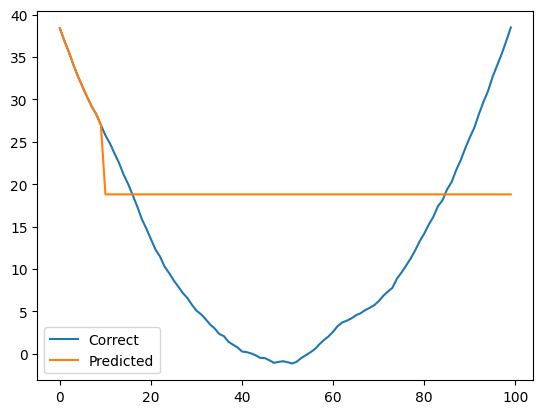

Epoch:266/1000 Error:976.7794423952773


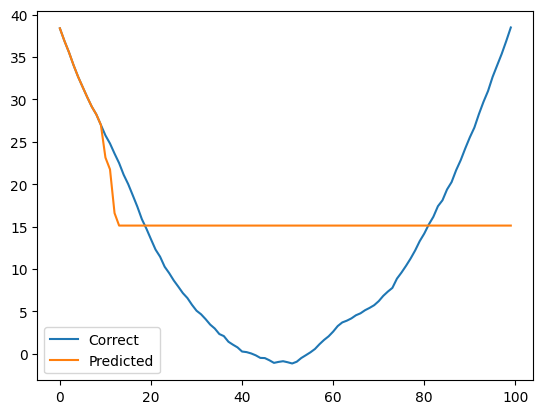

Epoch:271/1000 Error:588.2773151224543


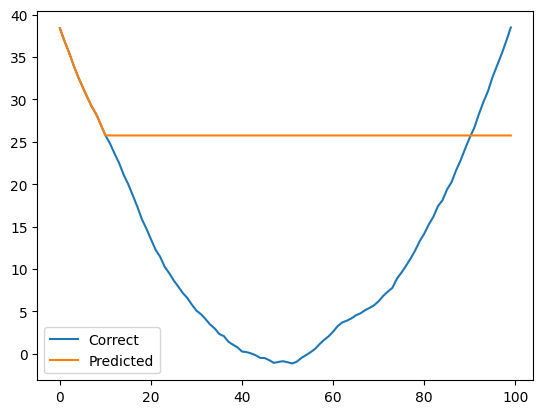

Epoch:276/1000 Error:584.46888952174


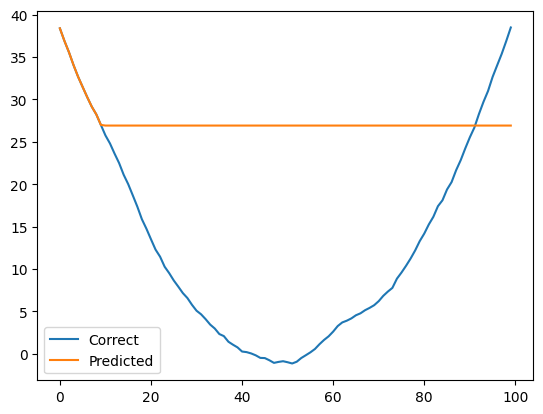

Epoch:281/1000 Error:556.6432032879395


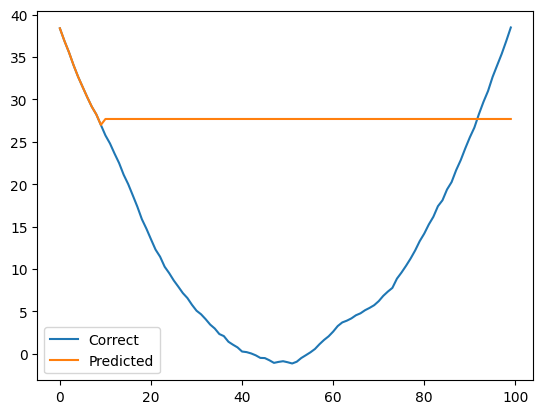

Epoch:286/1000 Error:1035.843672674186


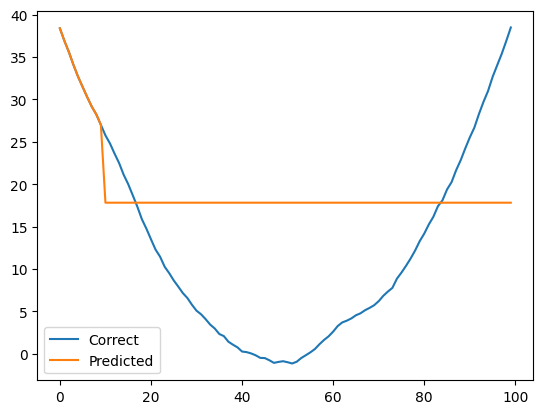

Epoch:291/1000 Error:354.2996283053208


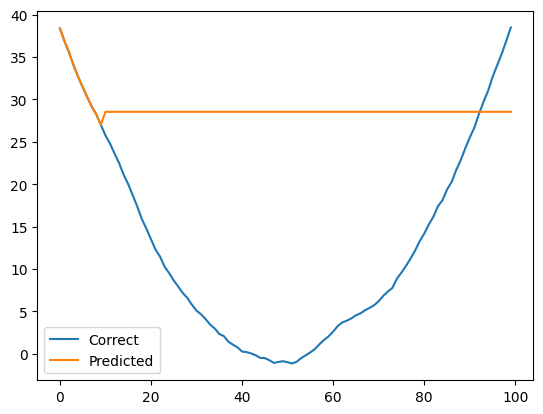

Epoch:296/1000 Error:352.4856132463017


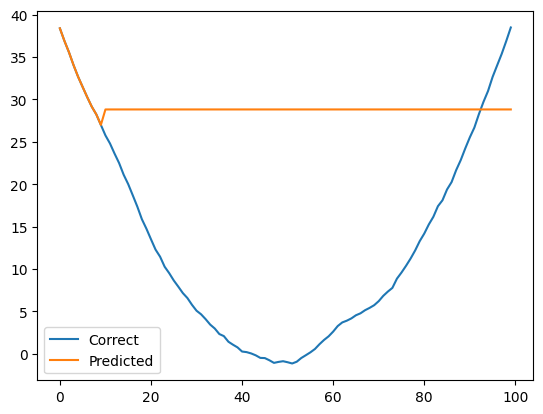

Epoch:301/1000 Error:499.581400571075


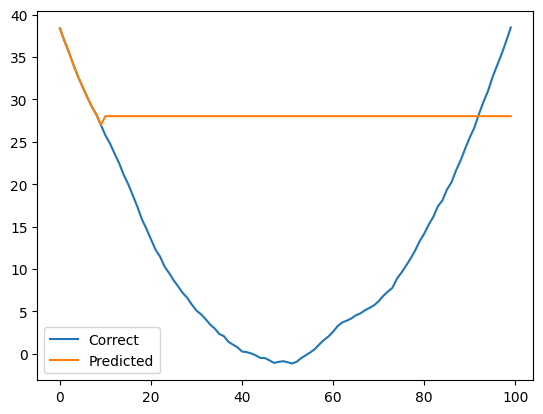

Epoch:306/1000 Error:380.87602986595596


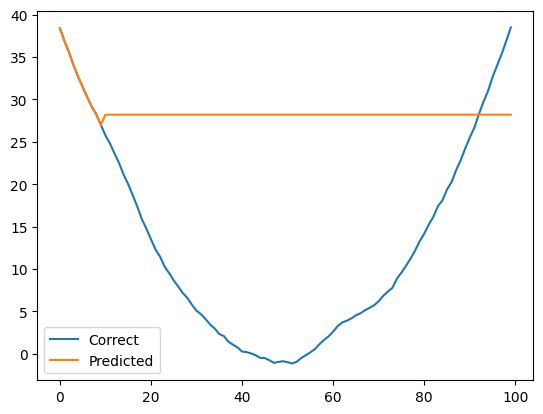

Epoch:311/1000 Error:332.48768395946485


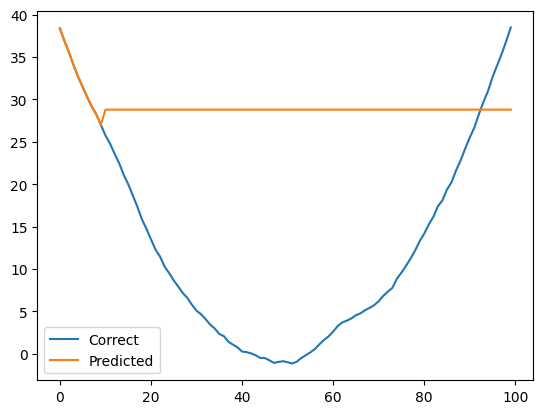

Epoch:316/1000 Error:307.78812474144485


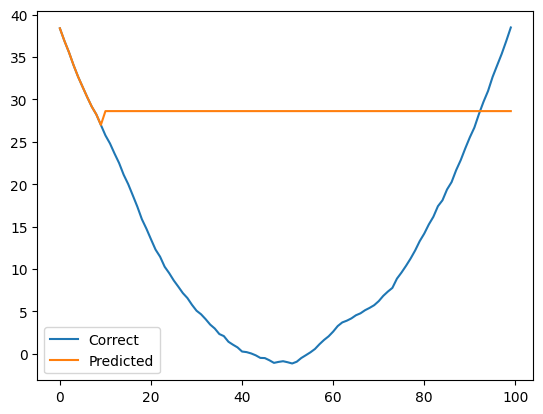

Epoch:321/1000 Error:452.3375186142482


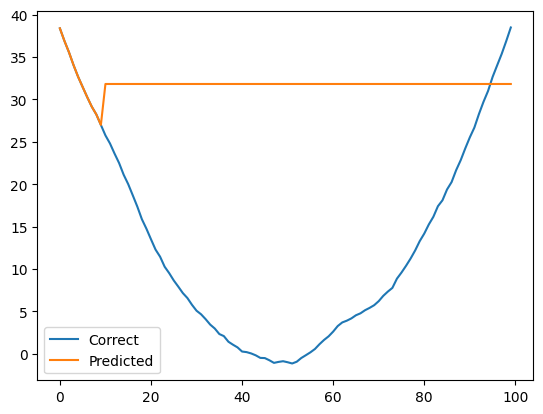

Epoch:326/1000 Error:289.3495267826788


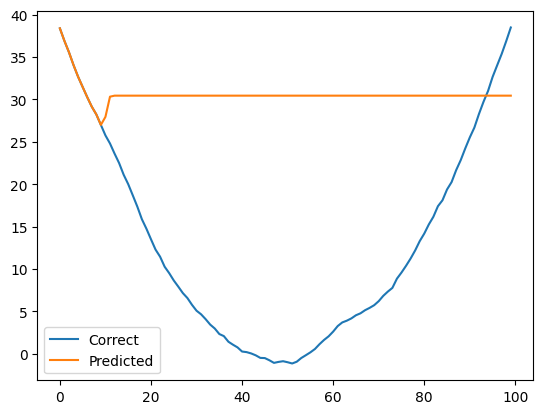

Epoch:331/1000 Error:240.7123996304955


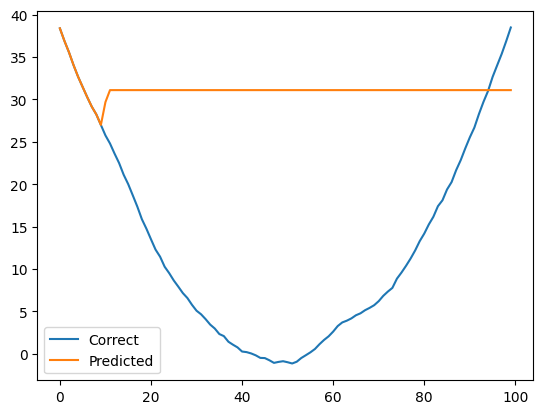

Epoch:336/1000 Error:283.6290483976534


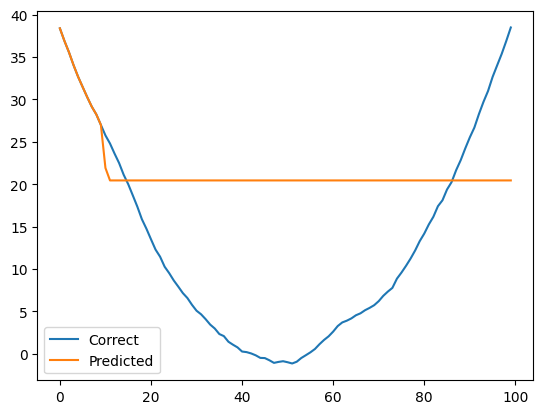

Epoch:341/1000 Error:750.5530291057777


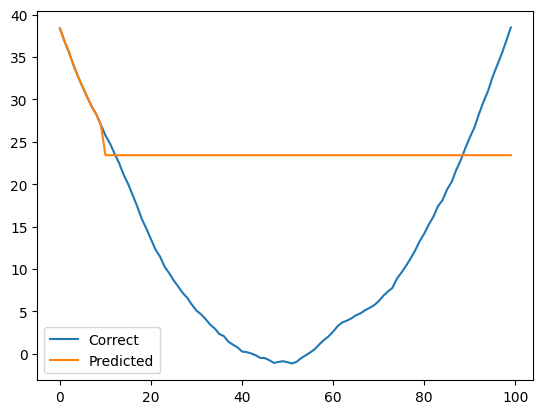

Epoch:346/1000 Error:835.0401084641894


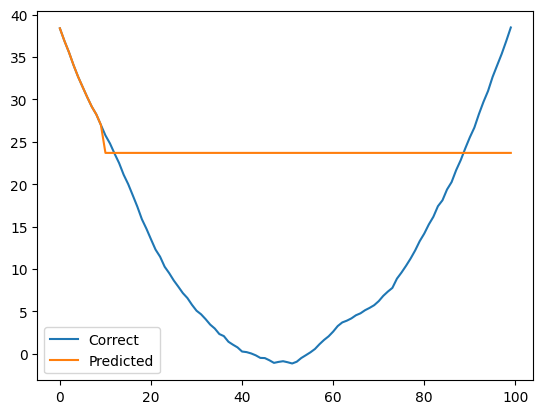

Epoch:351/1000 Error:1372.533227084171


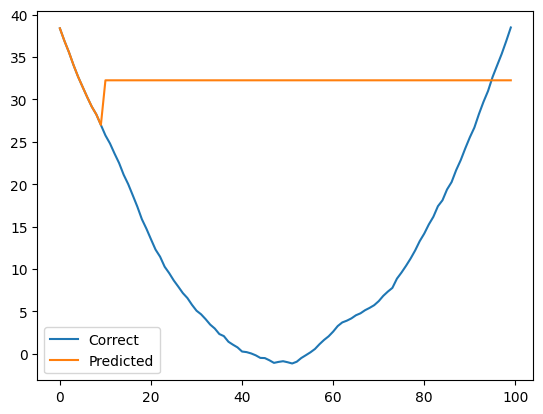

Epoch:356/1000 Error:304.98952758403675


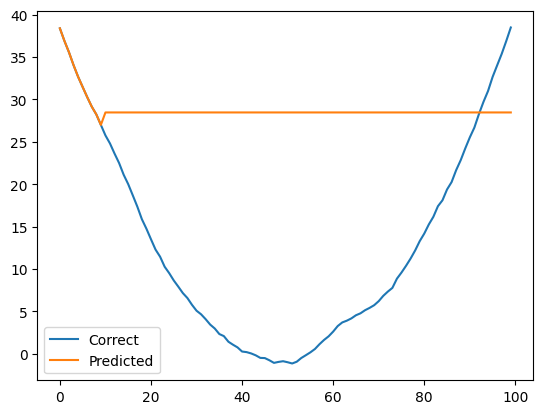

Epoch:361/1000 Error:1430.0192640305177


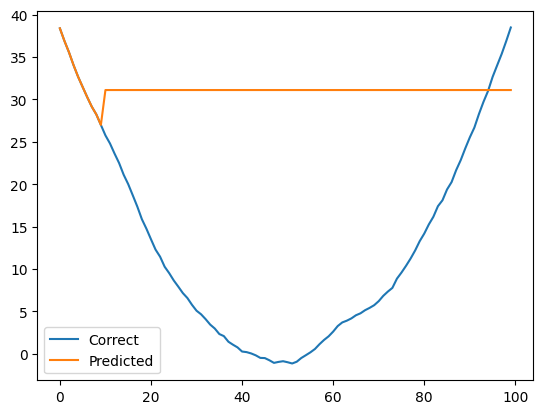

Epoch:366/1000 Error:393.22414421863346


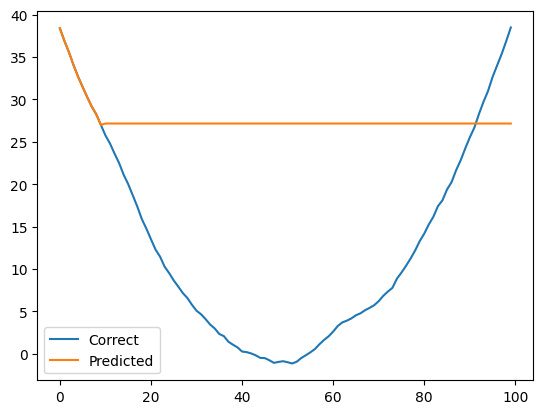

Epoch:371/1000 Error:275.1821958074352


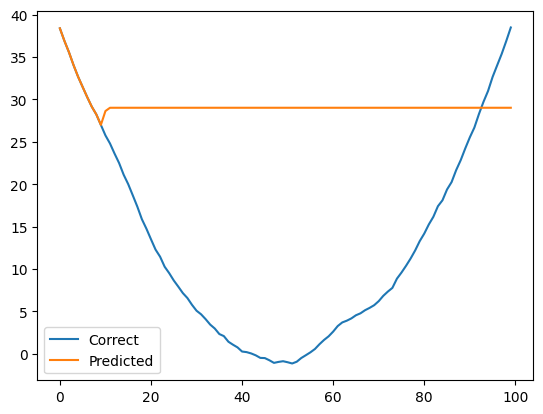

Epoch:376/1000 Error:246.5196898401838


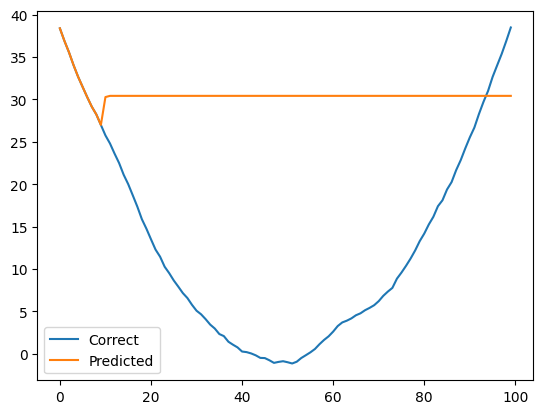

Epoch:381/1000 Error:398.1061385483823


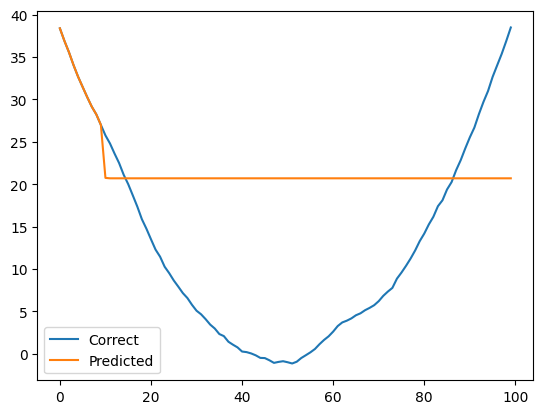

Epoch:386/1000 Error:1018.9144022082148


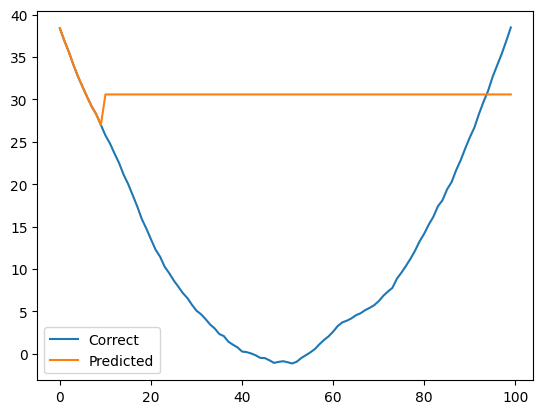

Epoch:391/1000 Error:252.81953044754644


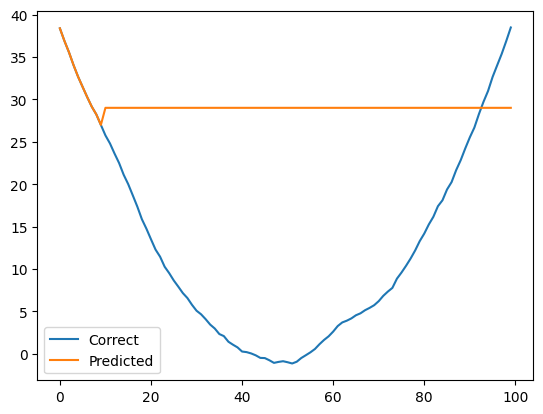

Epoch:396/1000 Error:177.0702551655684


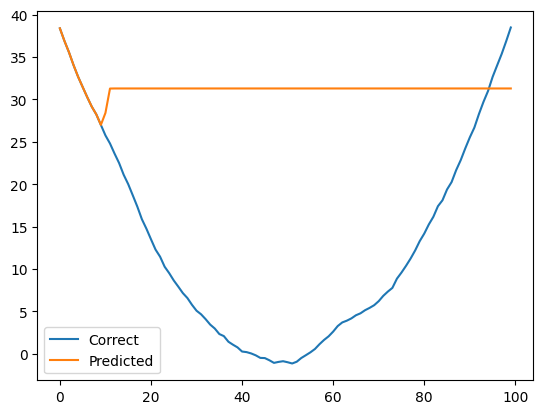

Epoch:401/1000 Error:725.5685570372153


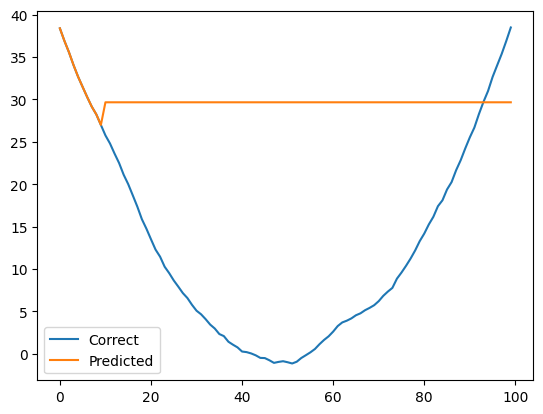

Epoch:406/1000 Error:654.3601774409146


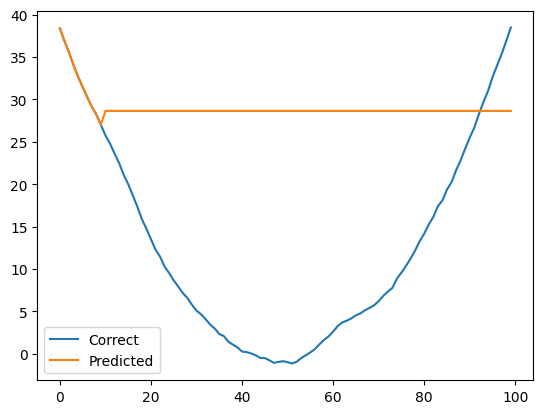

Epoch:411/1000 Error:246.25781130234648


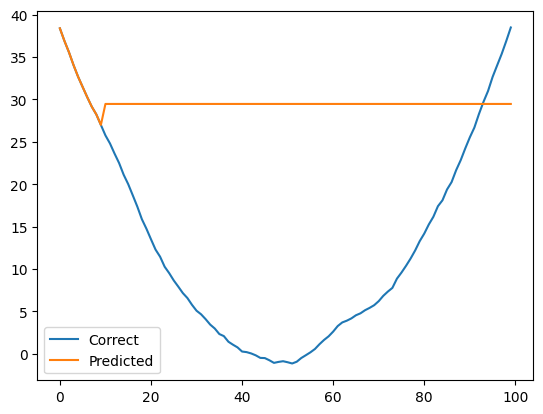

Epoch:416/1000 Error:173.04171549294705


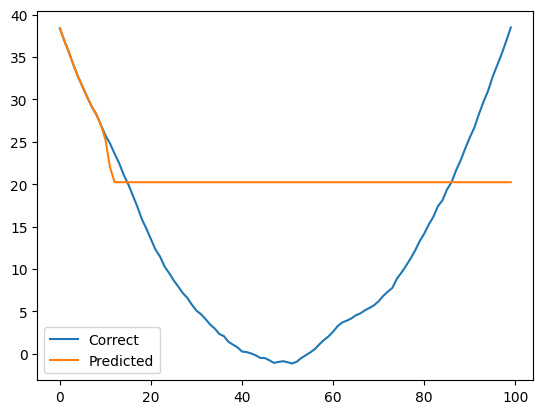

Epoch:421/1000 Error:318.48711356551235


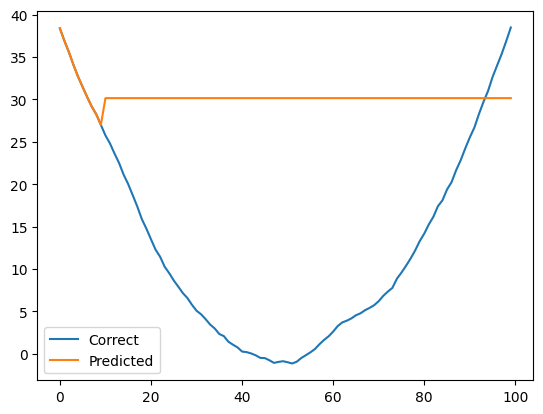

Epoch:426/1000 Error:178.77431306690525


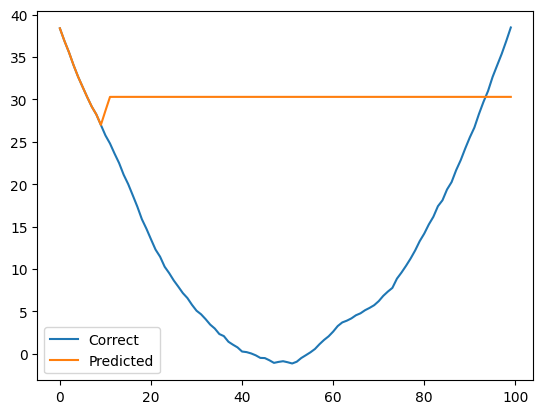

Epoch:431/1000 Error:226.4969311592873


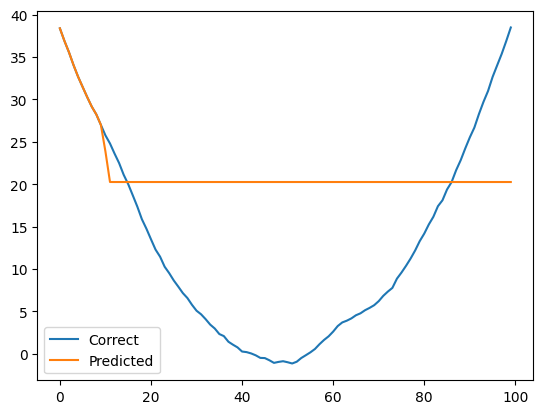

Epoch:436/1000 Error:701.799853420838


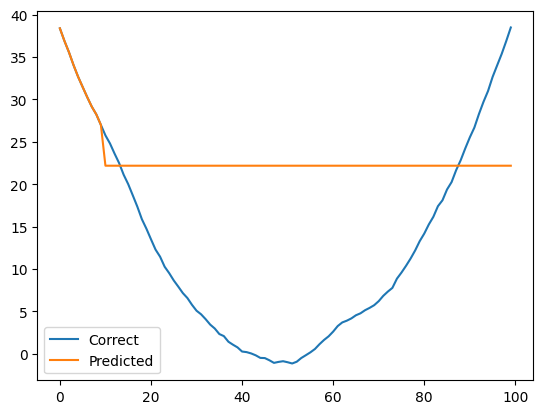

Epoch:441/1000 Error:549.2777721303363


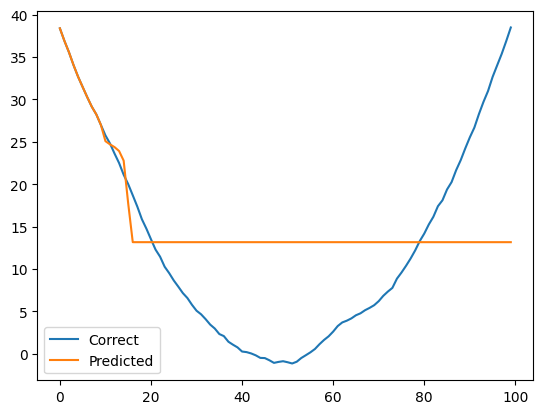

Epoch:446/1000 Error:535.5290472056238


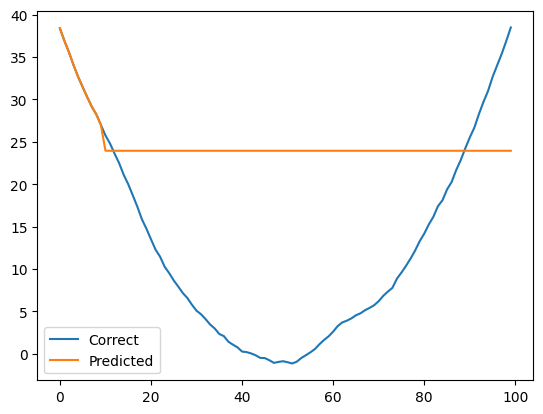

Epoch:451/1000 Error:384.99439107205455


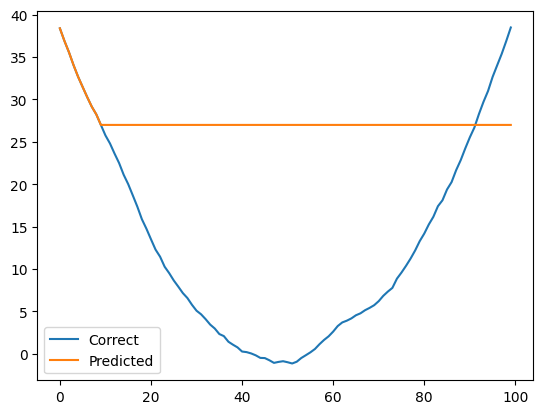

Epoch:456/1000 Error:415.080484071685


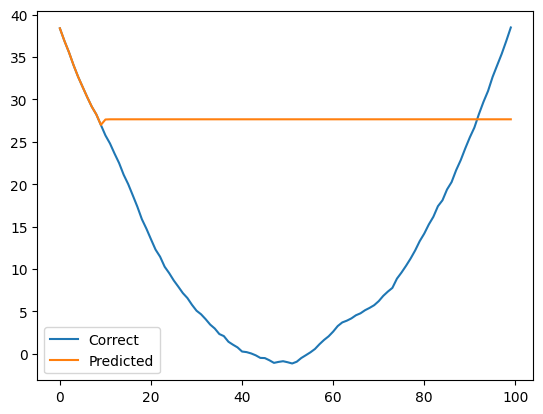

Epoch:461/1000 Error:543.1680046079725


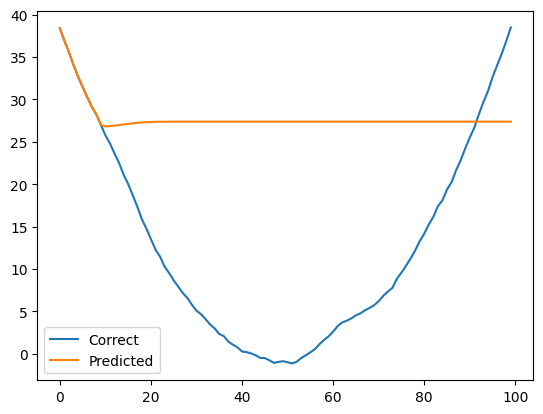

Epoch:466/1000 Error:806.053697846266


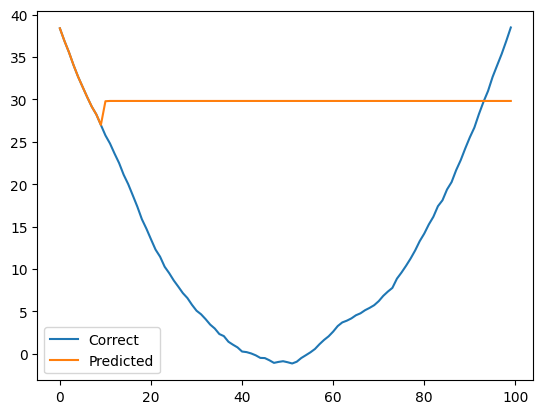

Epoch:471/1000 Error:559.7192894861133


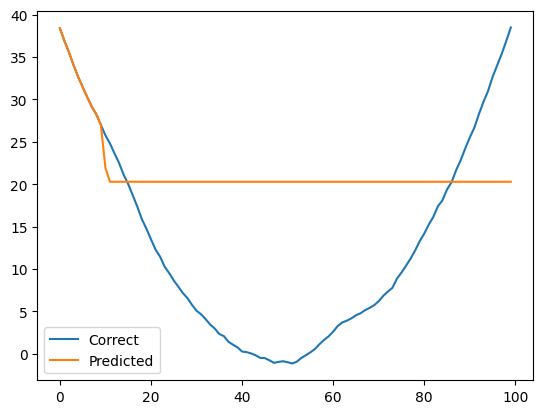

Epoch:476/1000 Error:421.7128174938851


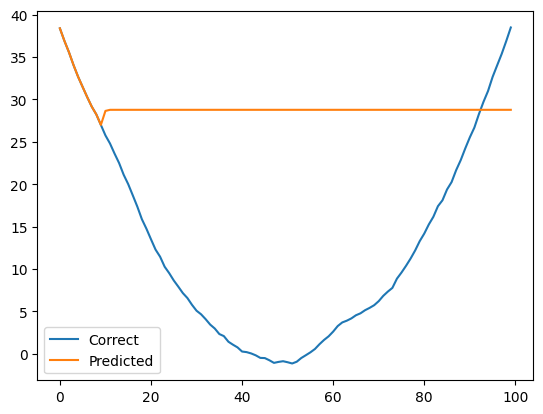

Epoch:481/1000 Error:481.5395125464423


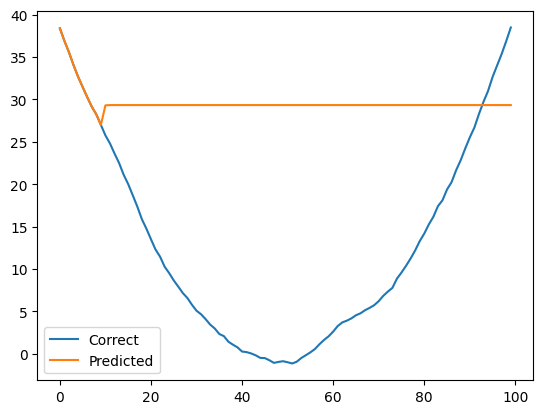

Epoch:486/1000 Error:387.40244944491224


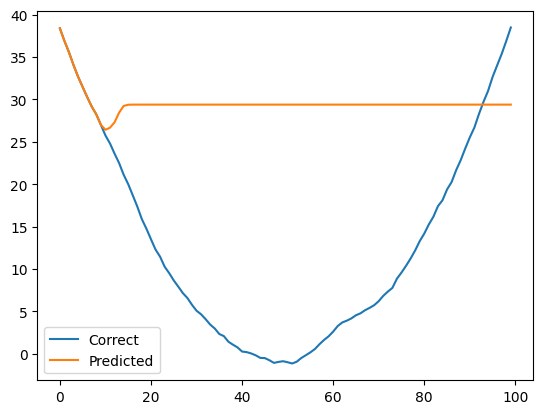

Epoch:491/1000 Error:418.21991000726877


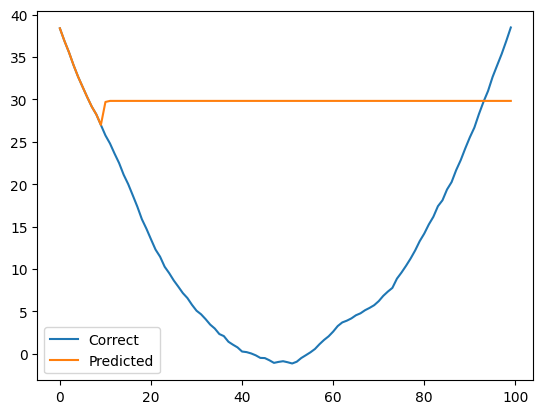

Epoch:496/1000 Error:230.07006173863252


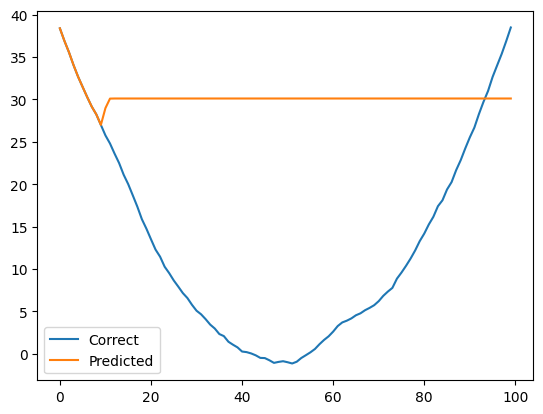

Epoch:501/1000 Error:377.42198046668386


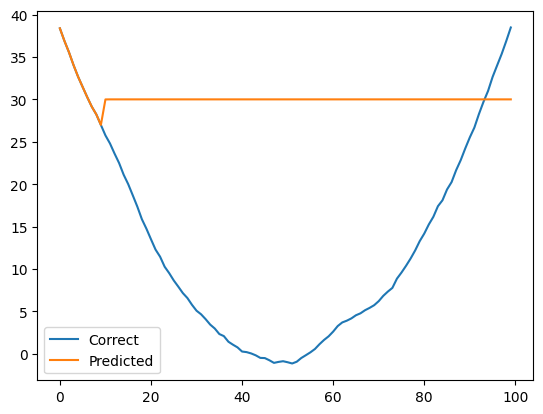

Epoch:506/1000 Error:924.6137921105441


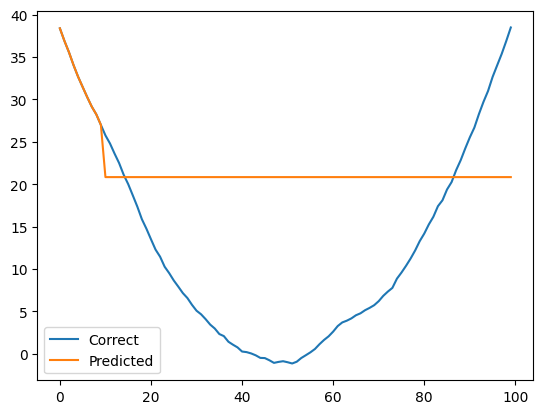

Epoch:511/1000 Error:625.4424792073203


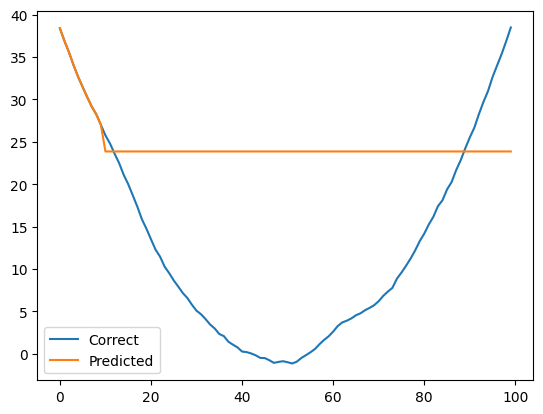

Epoch:516/1000 Error:1033.7179586327497


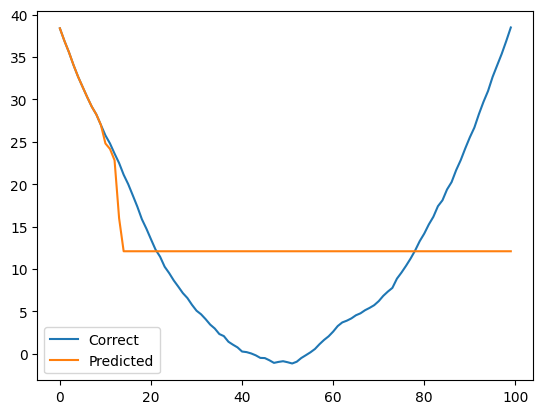

Epoch:521/1000 Error:691.0472064716929


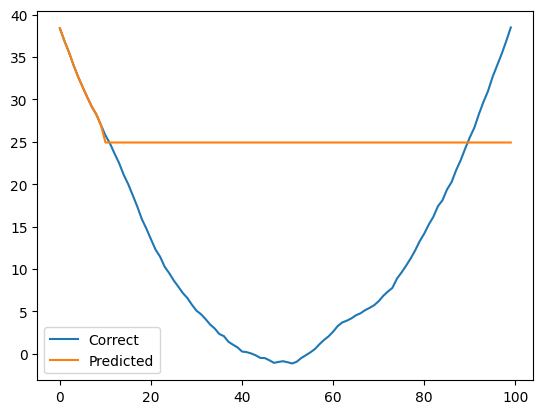

Epoch:526/1000 Error:657.5451899532846


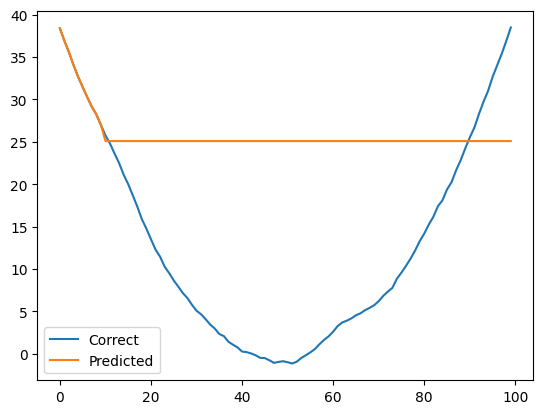

Epoch:531/1000 Error:674.5852609020859


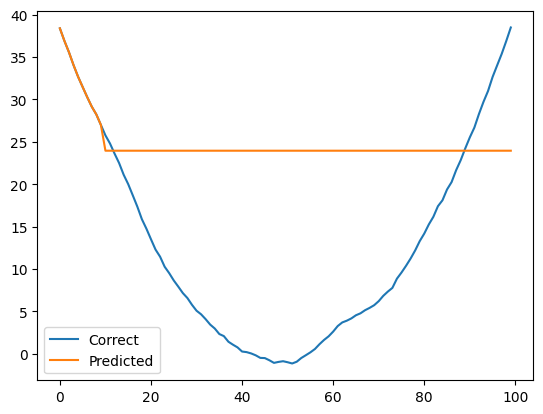

Epoch:536/1000 Error:719.6482026927214


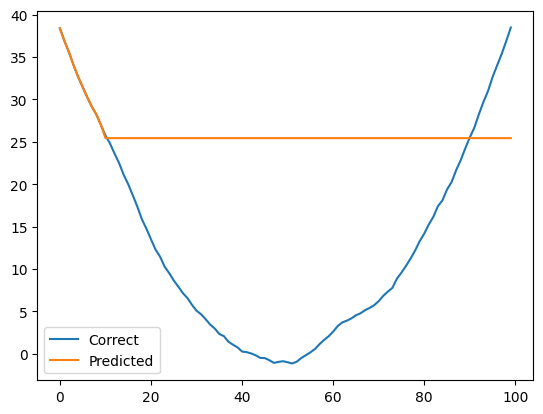

Epoch:541/1000 Error:639.4425276530749


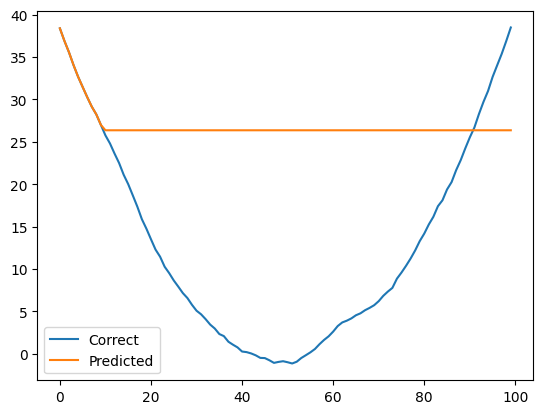

Epoch:546/1000 Error:662.8254054617146


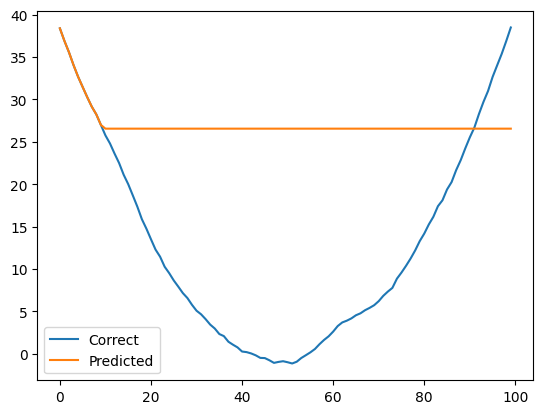

Epoch:551/1000 Error:797.5039955448239


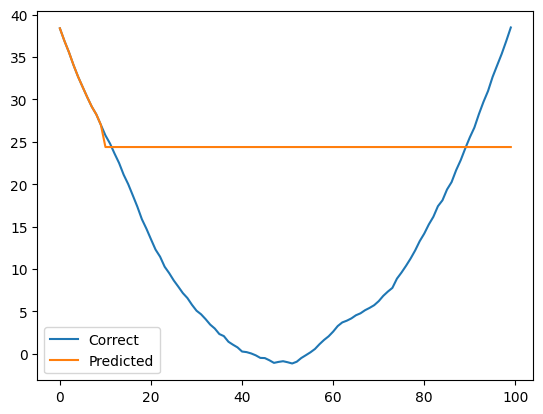

Epoch:556/1000 Error:569.4446592575802


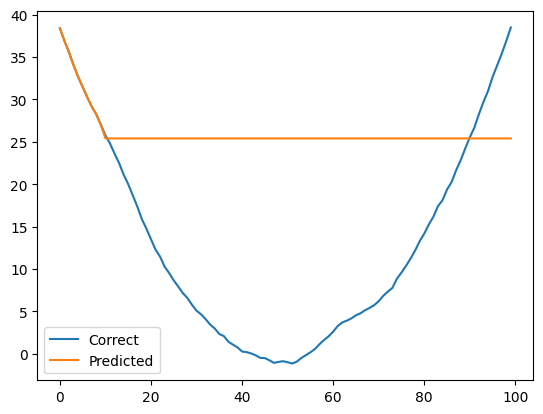

Epoch:561/1000 Error:1935.3694351006675


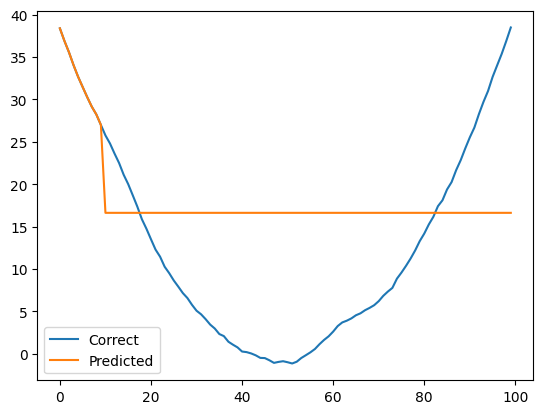

Epoch:566/1000 Error:1050.616170301814


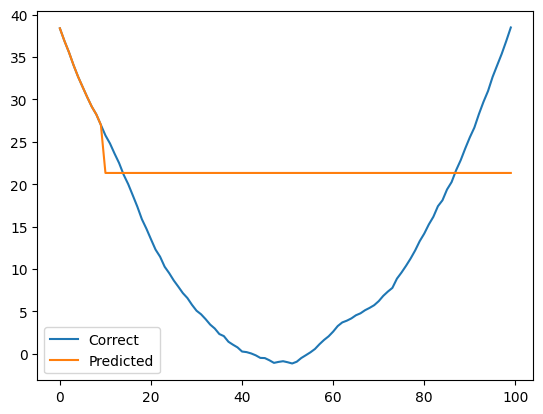

Epoch:571/1000 Error:722.0354434492292


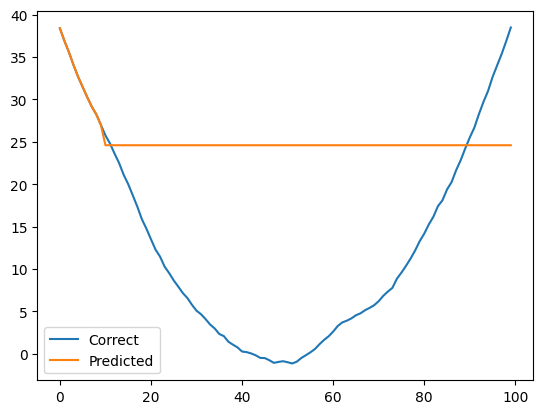

Epoch:576/1000 Error:735.6459559161246


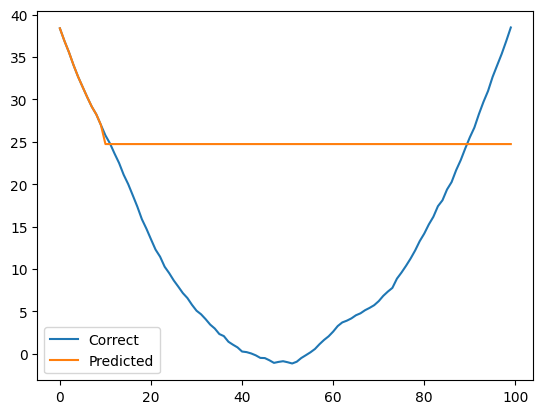

Epoch:581/1000 Error:603.0950184311879


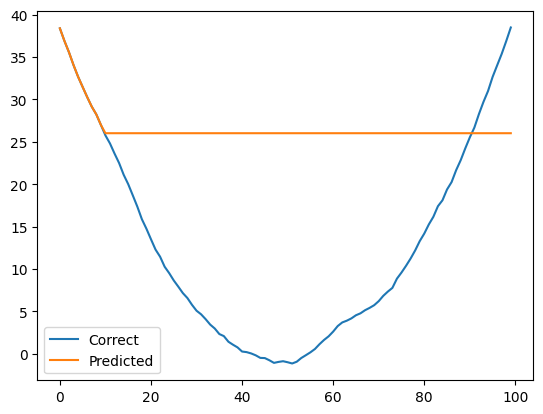

Epoch:586/1000 Error:596.2876570549166


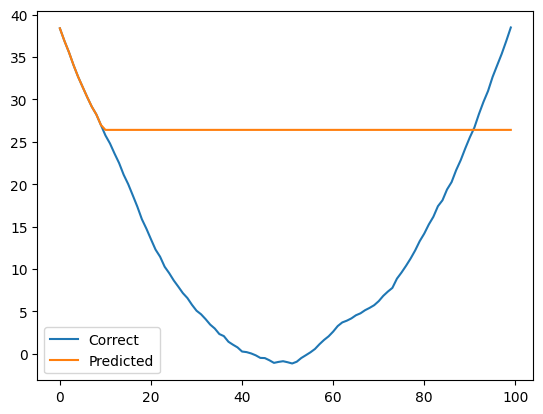

Epoch:591/1000 Error:709.526524013071


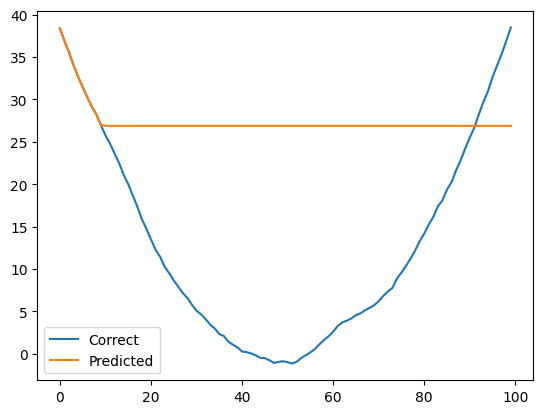

Epoch:596/1000 Error:561.9056016543487


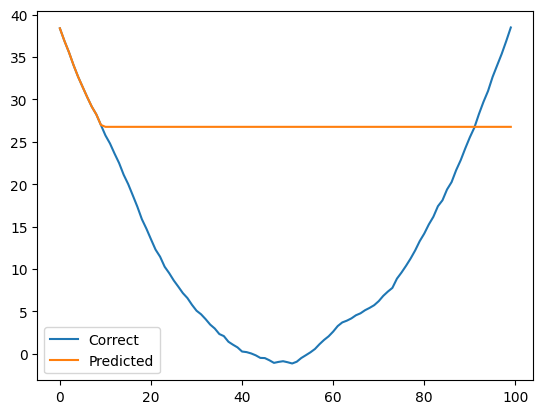

Epoch:601/1000 Error:443.94248591660113


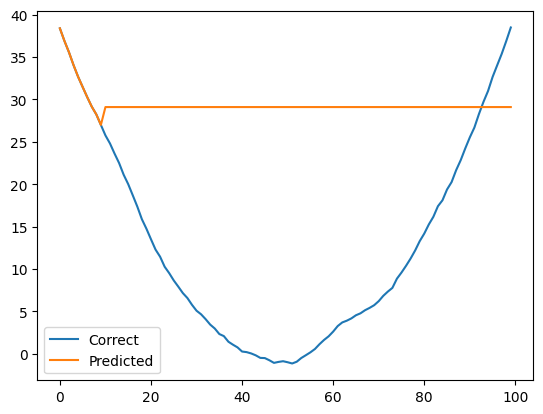

Epoch:606/1000 Error:592.8081409130684


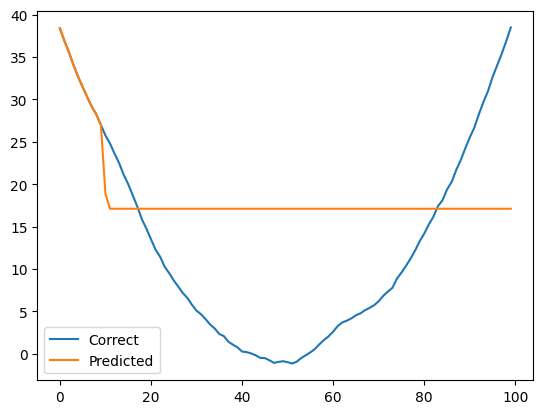

Epoch:611/1000 Error:937.8818628627903


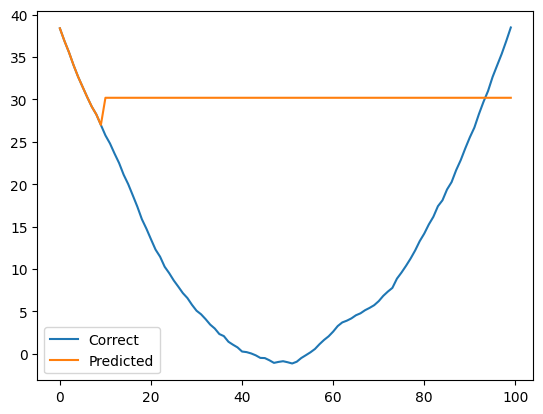

Epoch:616/1000 Error:523.2398539082315


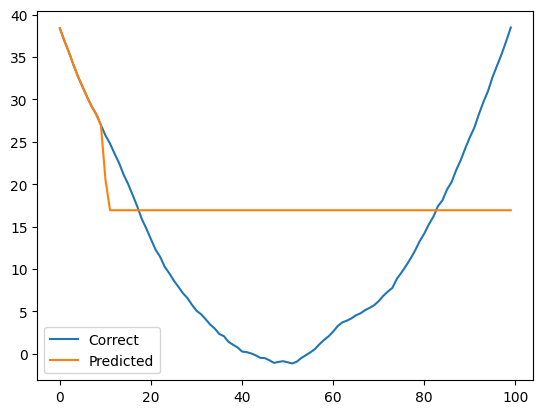

Epoch:621/1000 Error:620.6280550108119


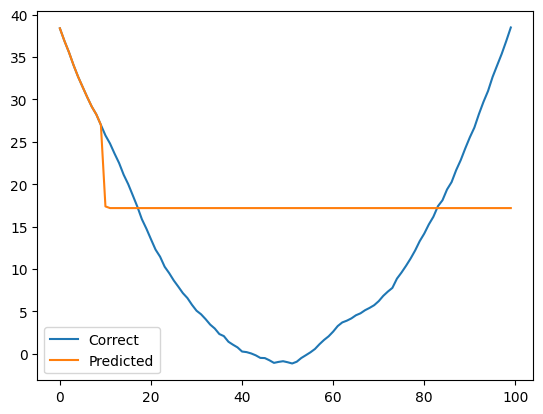

Epoch:626/1000 Error:479.5945334308411


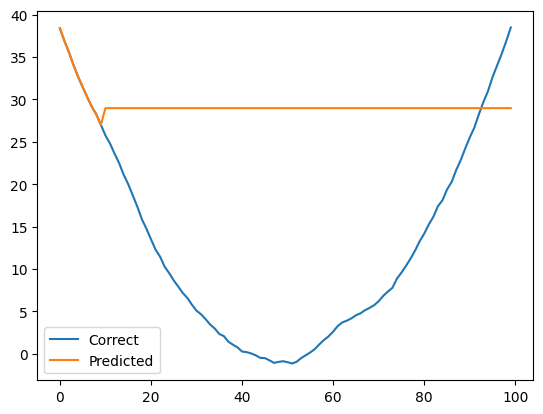

Epoch:631/1000 Error:392.6543219572702


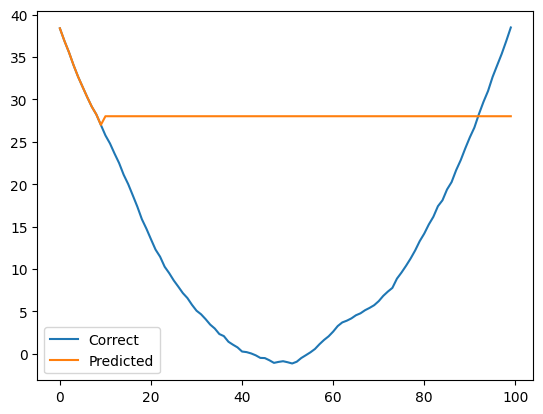

Epoch:636/1000 Error:415.63830456001483


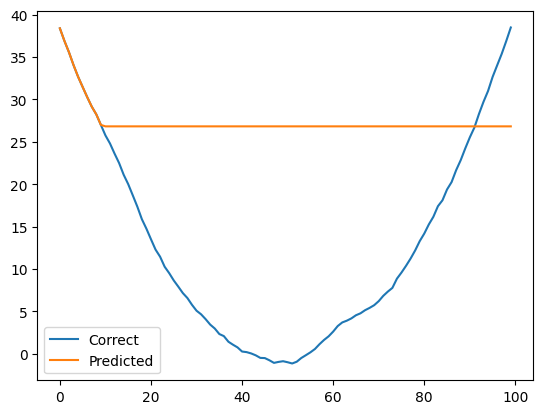

Epoch:641/1000 Error:333.0772219739686


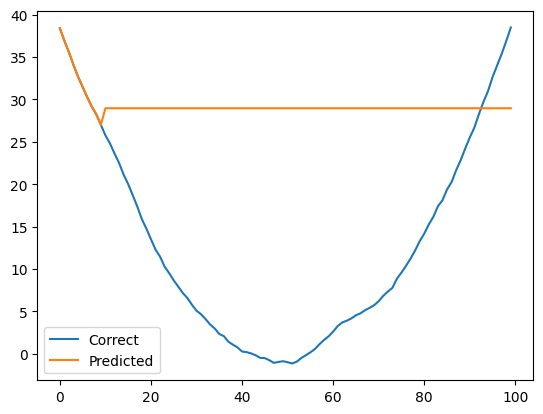

Epoch:646/1000 Error:358.7468670223035


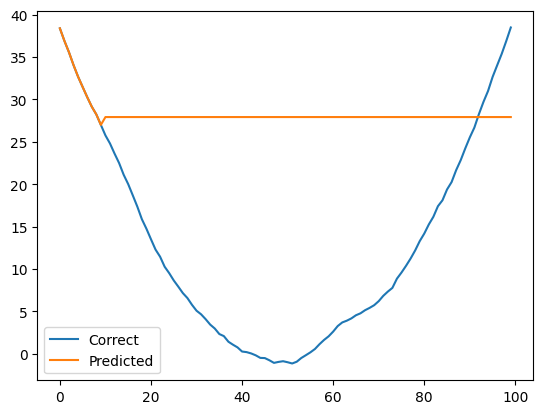

Epoch:651/1000 Error:353.69406519958716


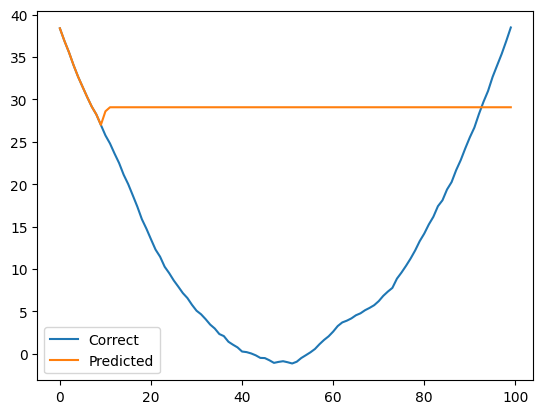

Epoch:656/1000 Error:361.44540466523705


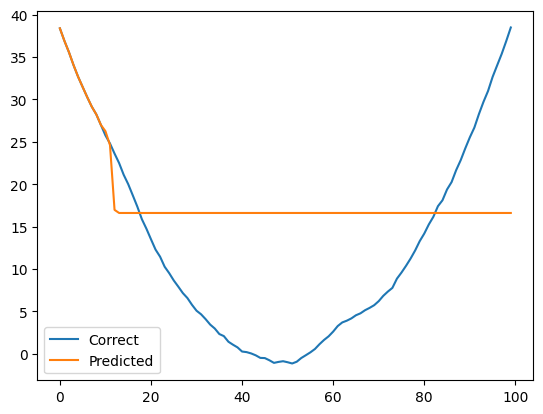

Epoch:661/1000 Error:1039.8616705082784


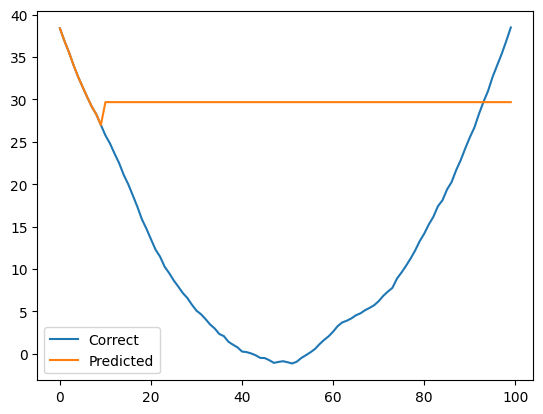

Epoch:666/1000 Error:472.9429590507466


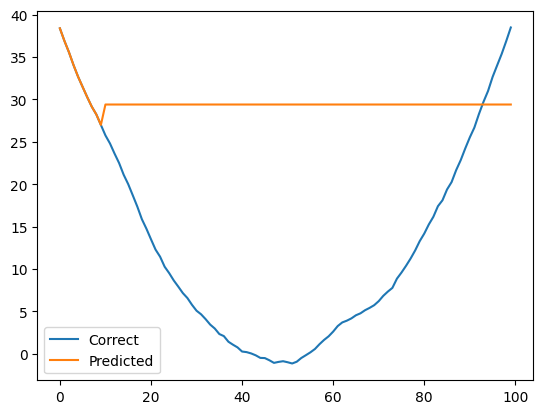

Epoch:671/1000 Error:1096.6267138760938


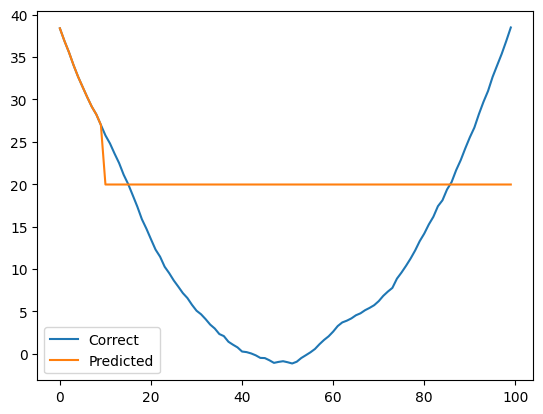

Epoch:676/1000 Error:872.9703697506418


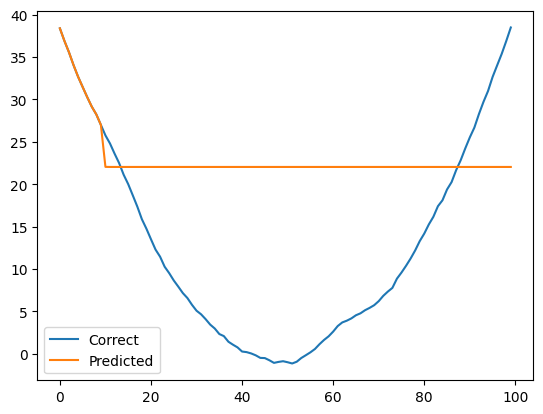

Epoch:681/1000 Error:909.4064414753444


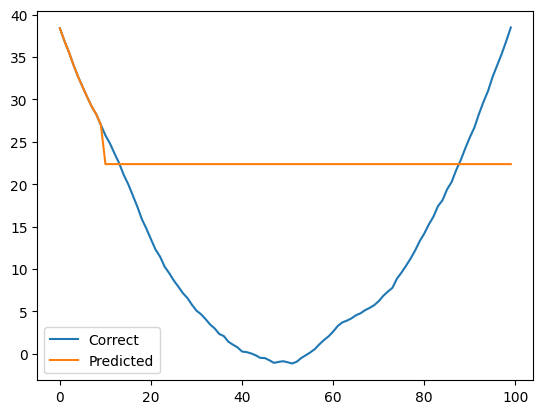

Epoch:686/1000 Error:822.9506079036277


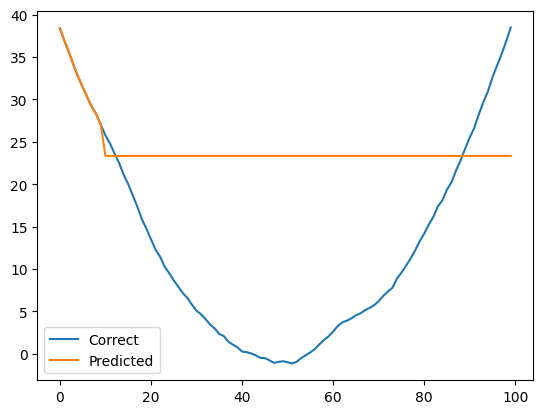

Epoch:691/1000 Error:598.4456868716135


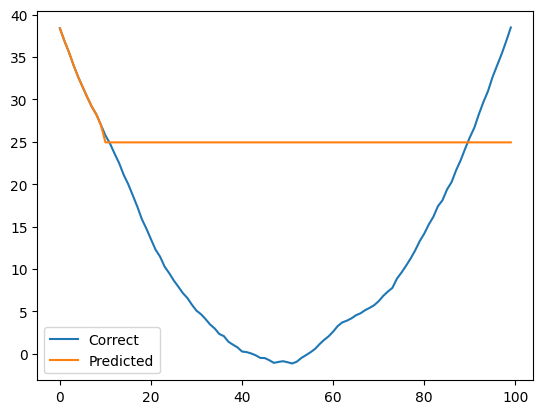

Epoch:696/1000 Error:676.5445840336483


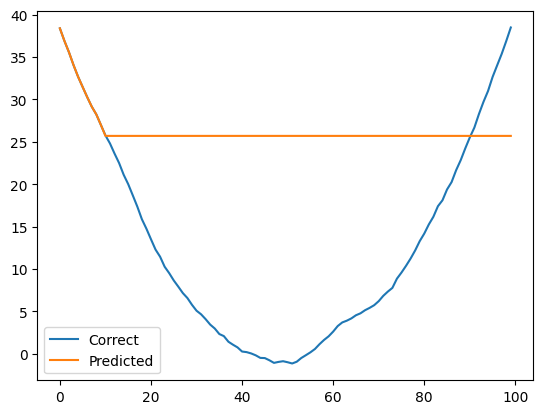

Epoch:701/1000 Error:2364.5336768768057


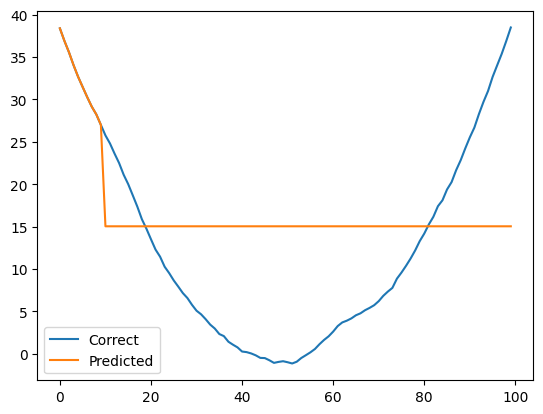

Epoch:706/1000 Error:1612.6996861194011


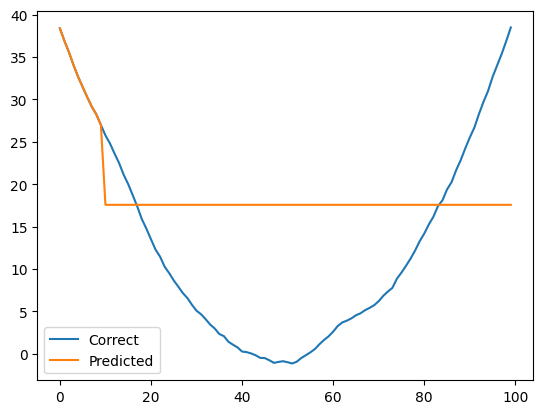

Epoch:711/1000 Error:758.7889651741332


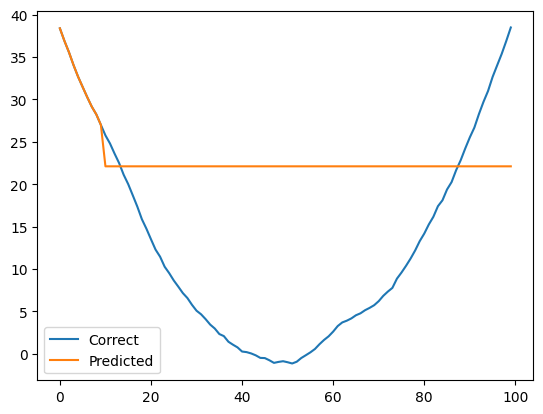

Epoch:716/1000 Error:572.9757633066955


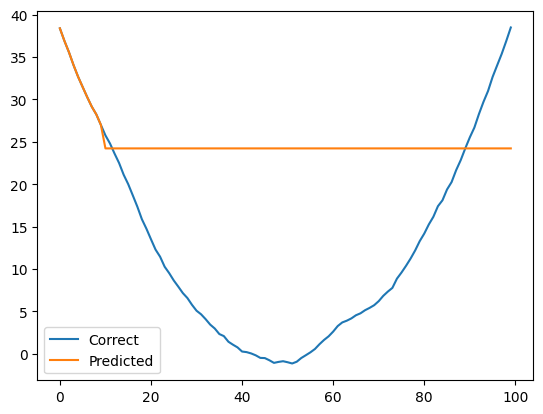

Epoch:721/1000 Error:444.56502003945445


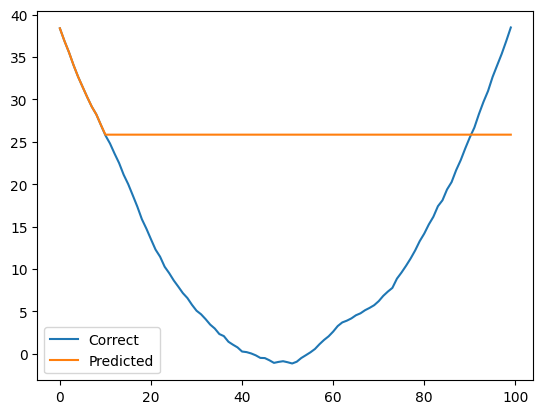

Epoch:726/1000 Error:396.37496865144703


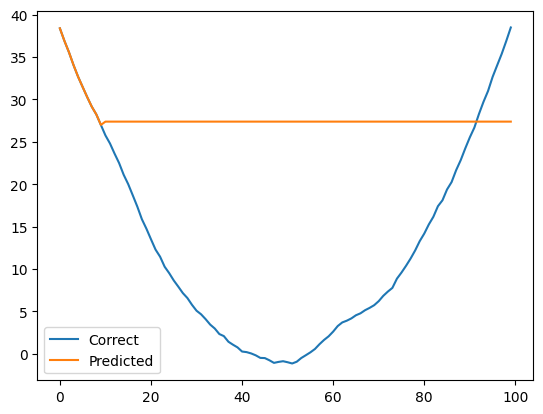

Epoch:731/1000 Error:340.5422132198035


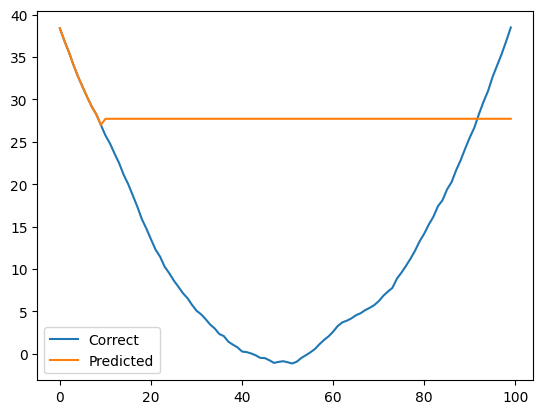

Epoch:736/1000 Error:415.28199667285253


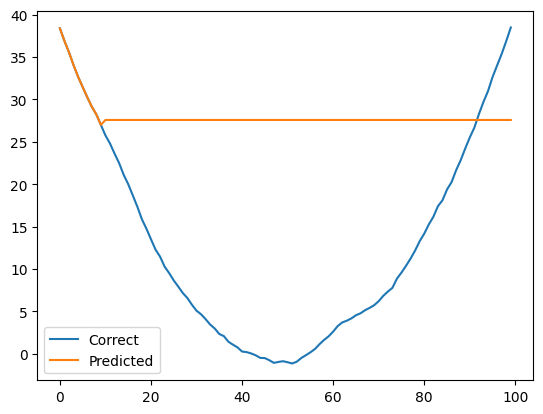

Epoch:741/1000 Error:312.3126365234433


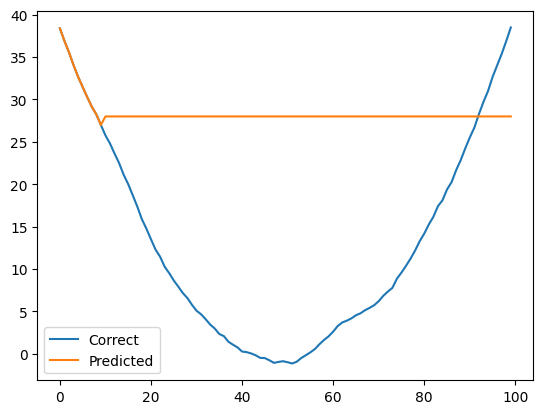

Epoch:746/1000 Error:295.325704357488


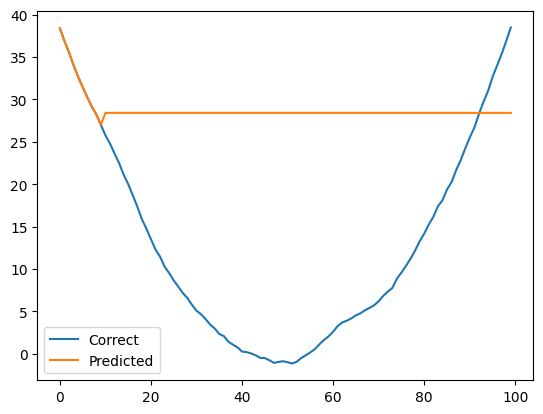

Epoch:751/1000 Error:1106.8574607813016


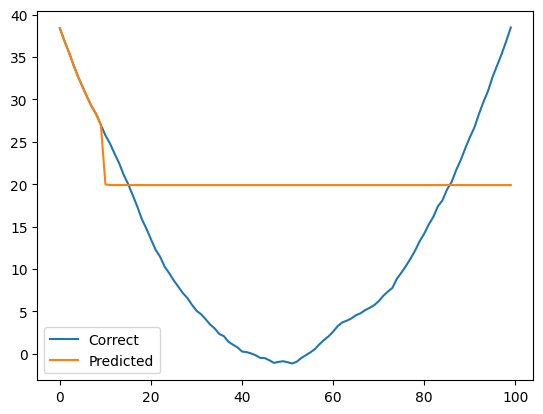

Epoch:756/1000 Error:939.4525246541432


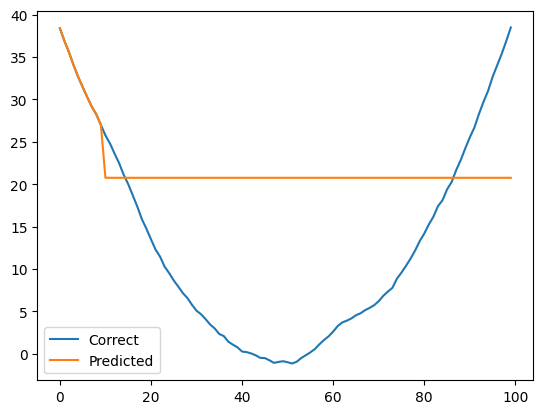

Epoch:761/1000 Error:882.9881555717421


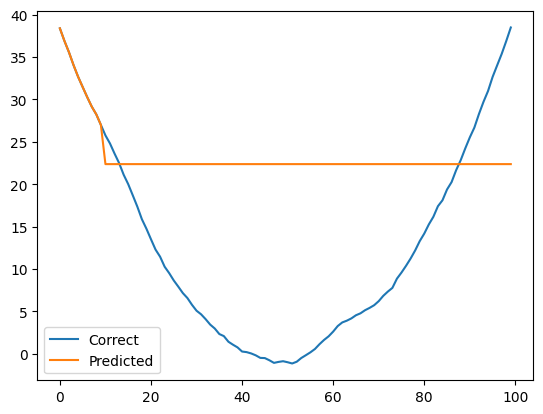

Epoch:766/1000 Error:781.740934519801


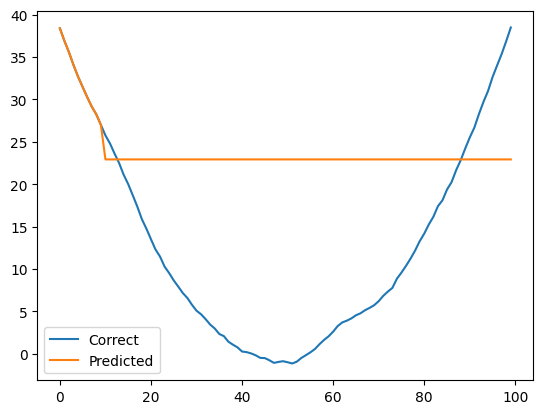

Epoch:771/1000 Error:864.9233768571976


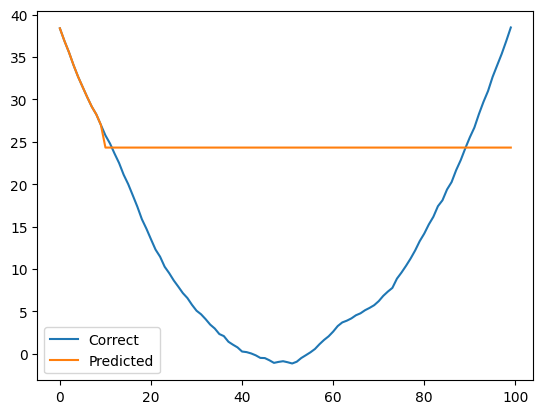

Epoch:776/1000 Error:3594.3433471615094


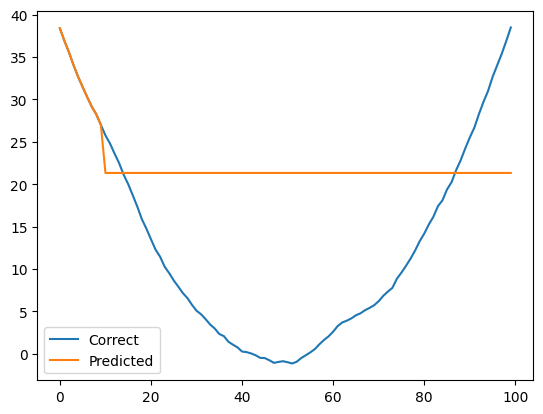

Epoch:781/1000 Error:1111.8481908314036


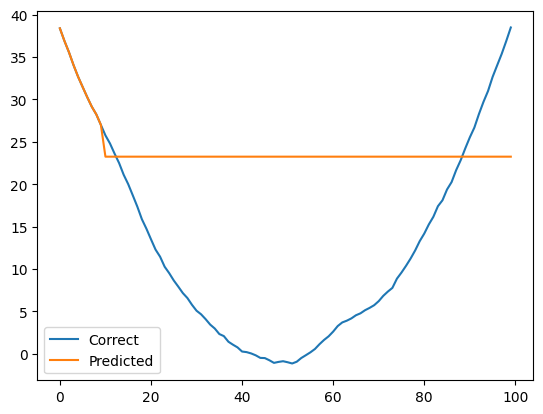

Epoch:786/1000 Error:1032.6297255737009


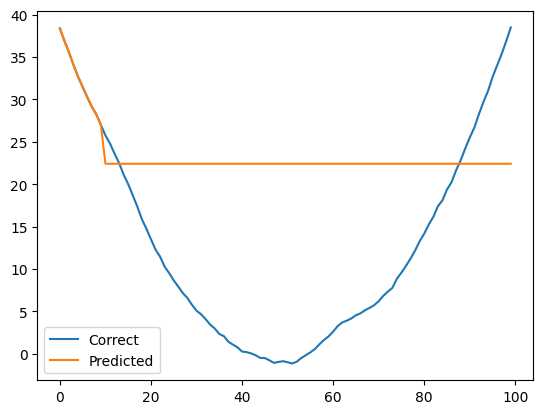

Epoch:791/1000 Error:1979.465863326298


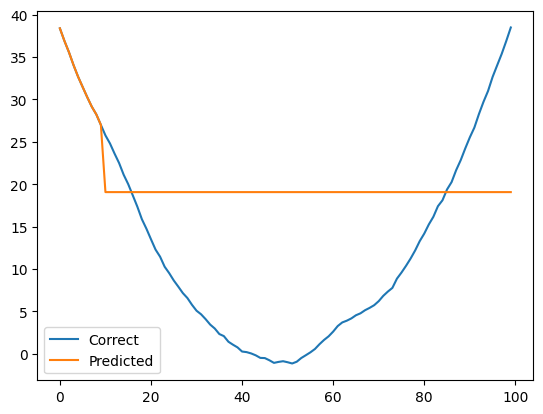

Epoch:796/1000 Error:1333.6475026545615


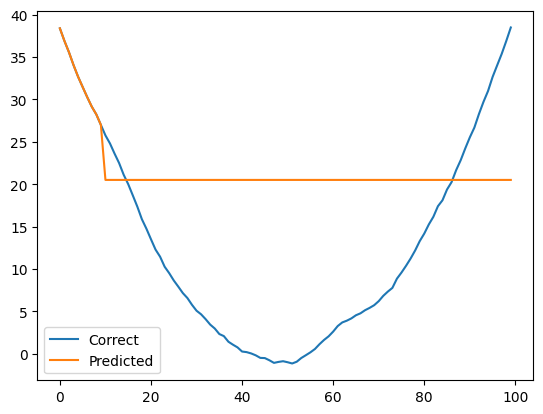

Epoch:801/1000 Error:1309.1303203861053


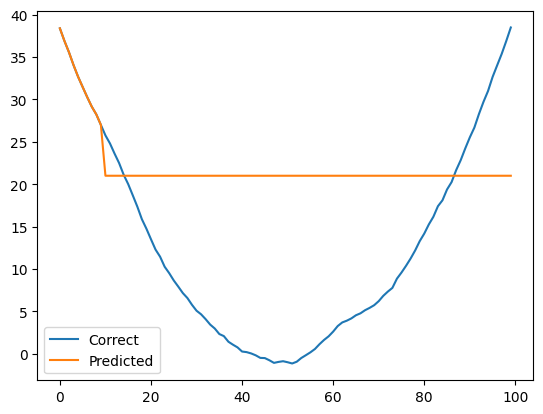

Epoch:806/1000 Error:925.7874148784149


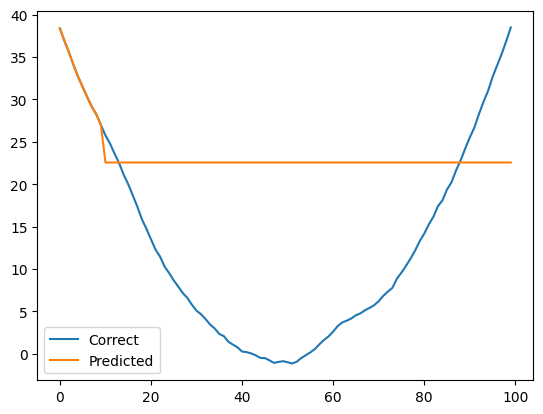

Epoch:811/1000 Error:1145.6332139210926


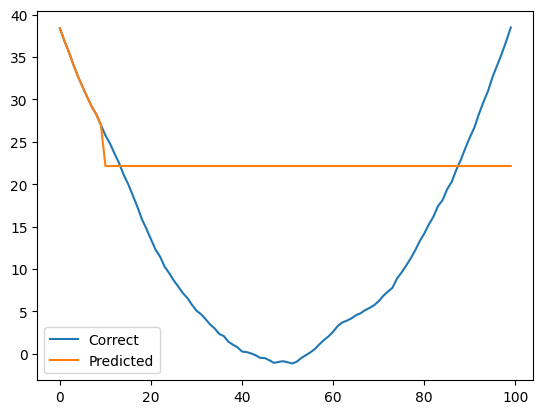

Epoch:816/1000 Error:1140.9145812547529


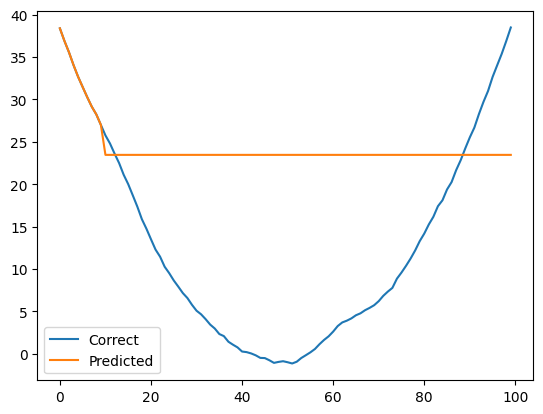

Epoch:821/1000 Error:890.6652154219476


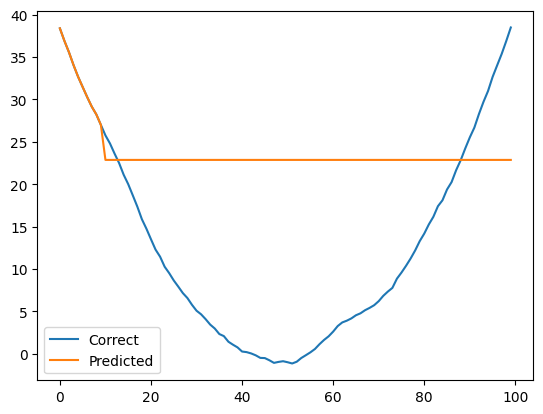

Epoch:826/1000 Error:908.61788391951


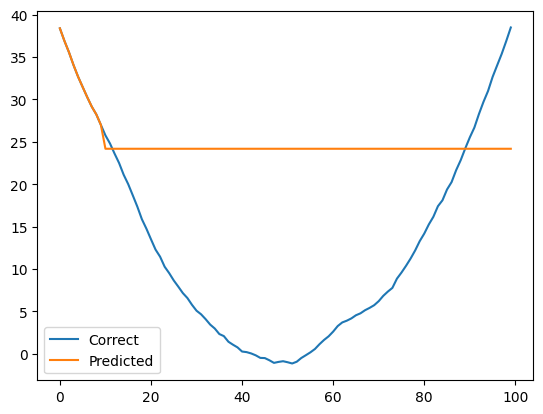

Epoch:831/1000 Error:1091.7671318654639


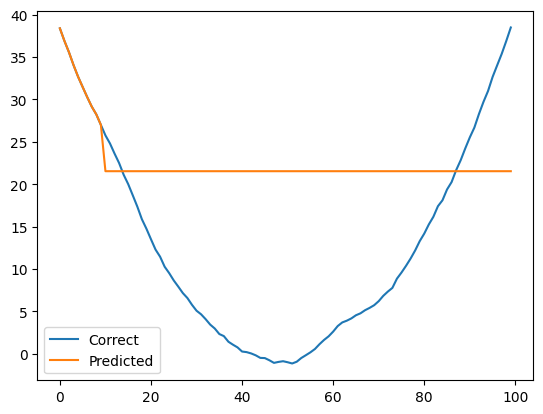

Epoch:836/1000 Error:904.2457235026657


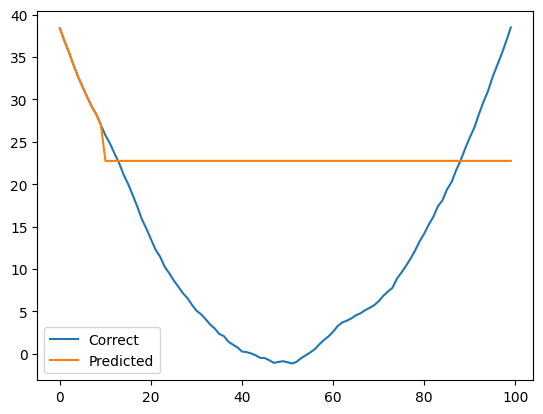

Epoch:841/1000 Error:935.6100191050093


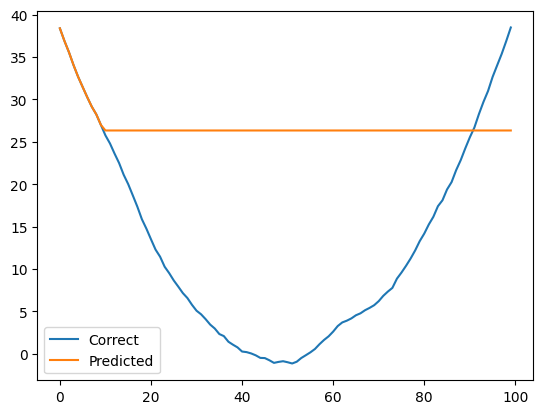

Epoch:846/1000 Error:922.1162254051671


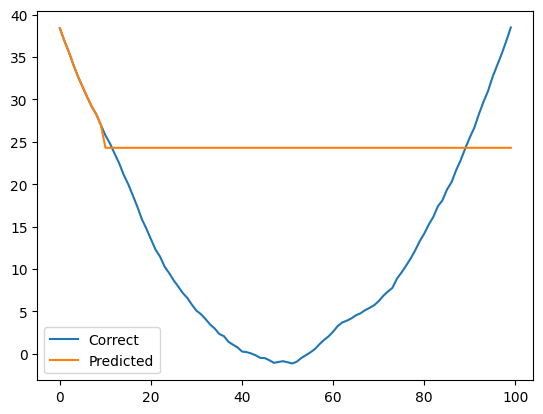

Epoch:851/1000 Error:916.5433982839909


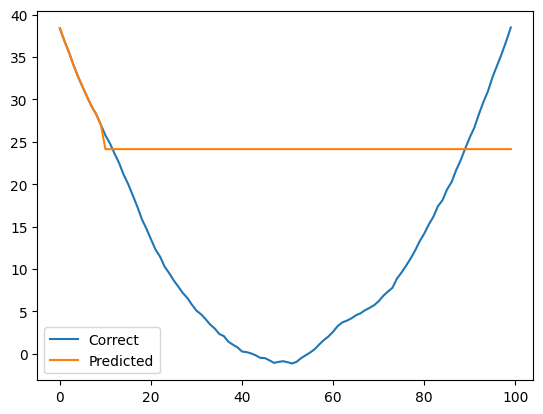

Epoch:856/1000 Error:912.2424715177366


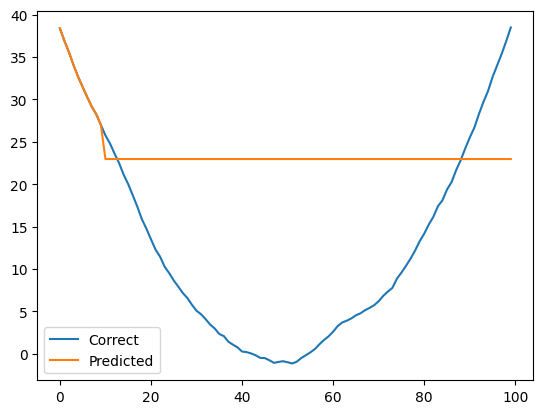

Epoch:861/1000 Error:1316.8819695482916


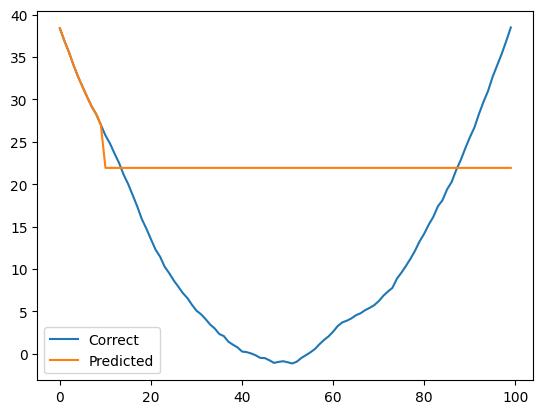

Epoch:866/1000 Error:934.174444421605


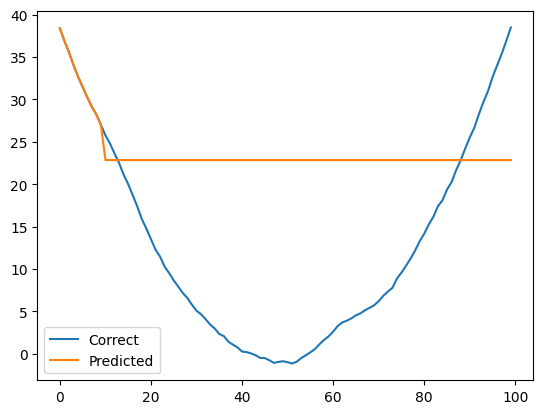

Epoch:871/1000 Error:929.9386754747997


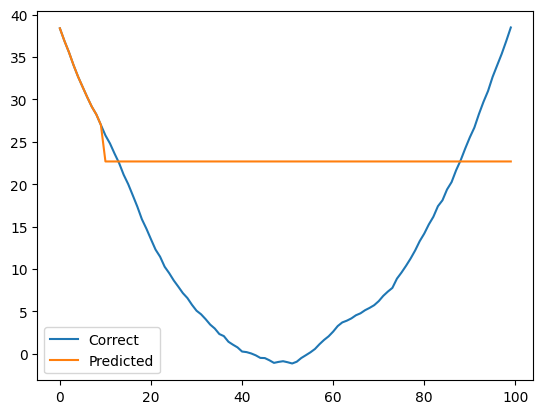

Epoch:876/1000 Error:3739.757763242062


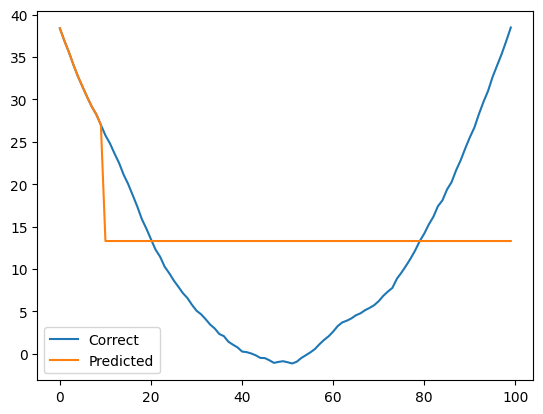

Epoch:881/1000 Error:920.0745308146838


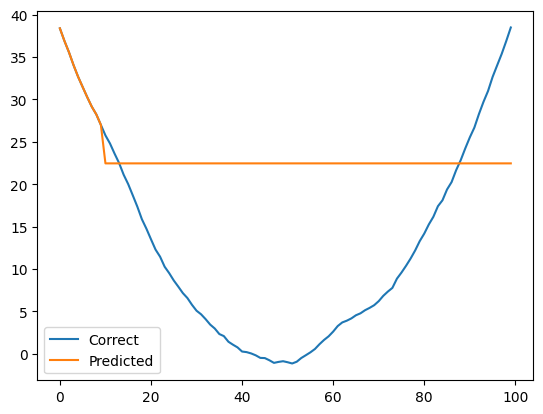

Epoch:886/1000 Error:843.8076785896106


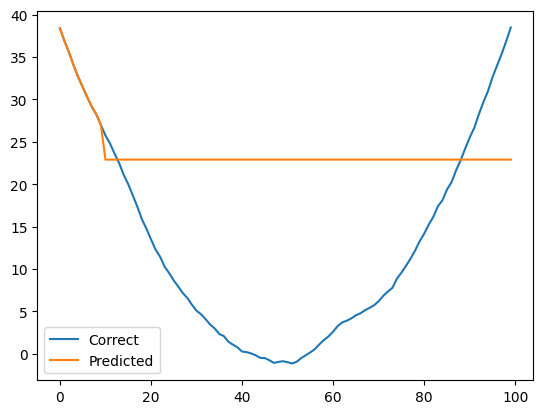

Epoch:891/1000 Error:813.6213808848712


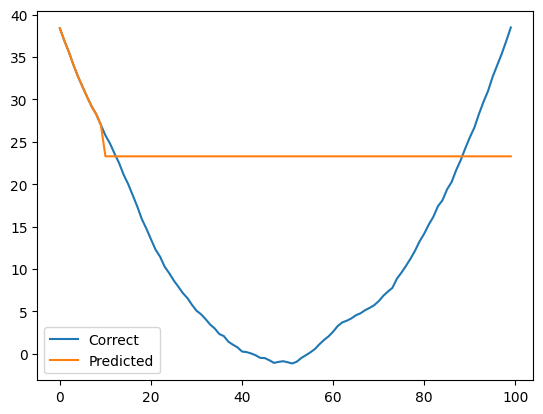

Epoch:896/1000 Error:813.9192829586602


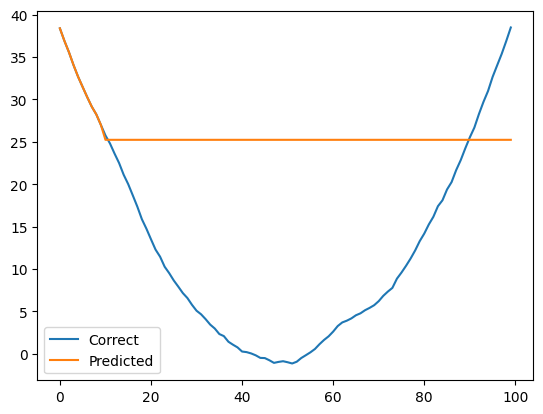

Epoch:901/1000 Error:992.2664397561887


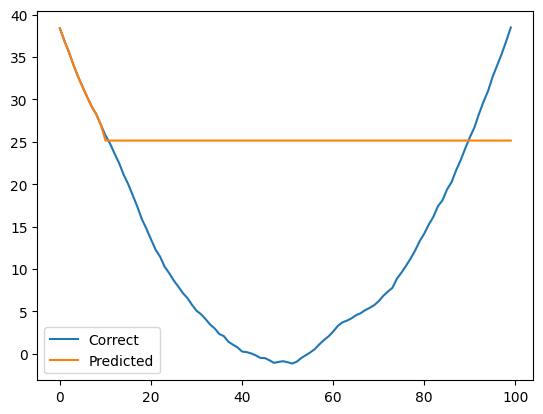

Epoch:906/1000 Error:3518.6779066996523


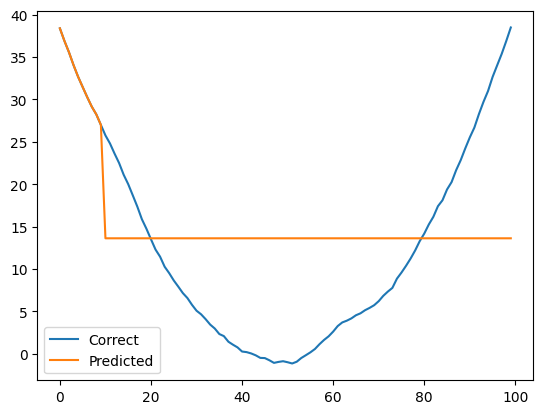

Epoch:911/1000 Error:3394.5765399787715


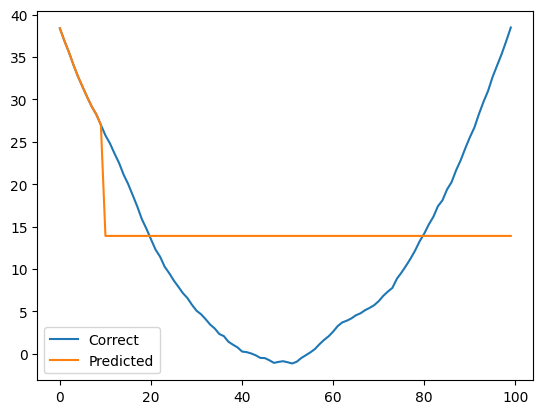

Epoch:916/1000 Error:3358.0566245670734


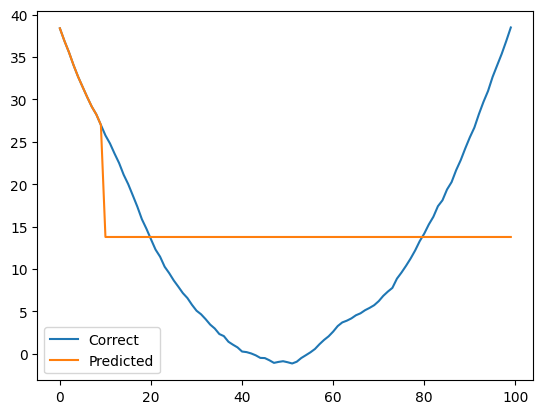

Epoch:921/1000 Error:3344.0580084213907


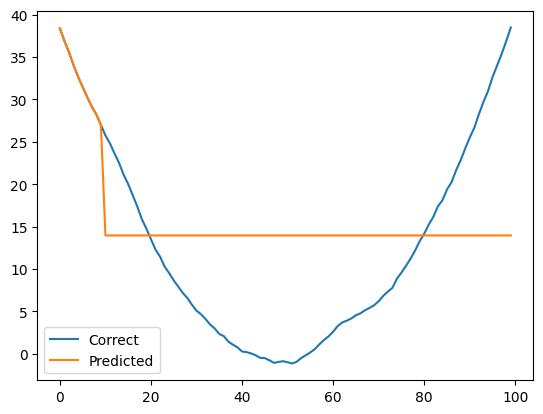

Epoch:926/1000 Error:1174.6569079167934


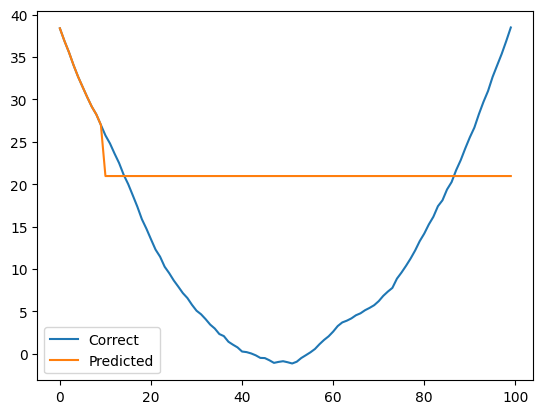

Epoch:931/1000 Error:953.5804585690714


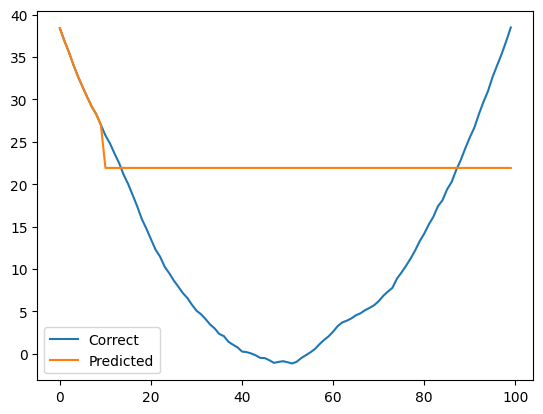

Epoch:936/1000 Error:849.9932253637991


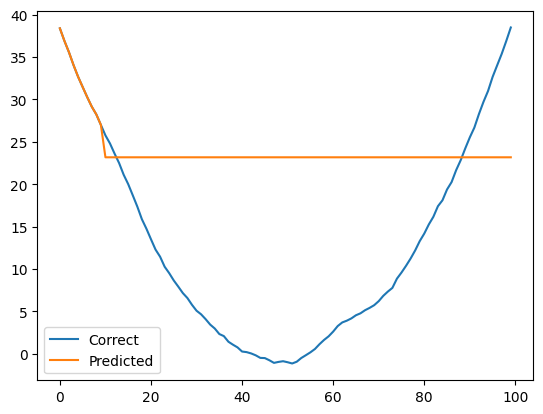

Epoch:941/1000 Error:1353.9063426461425


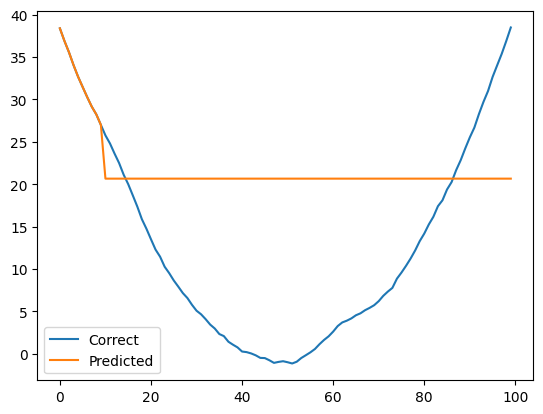

Epoch:946/1000 Error:819.5736301435511


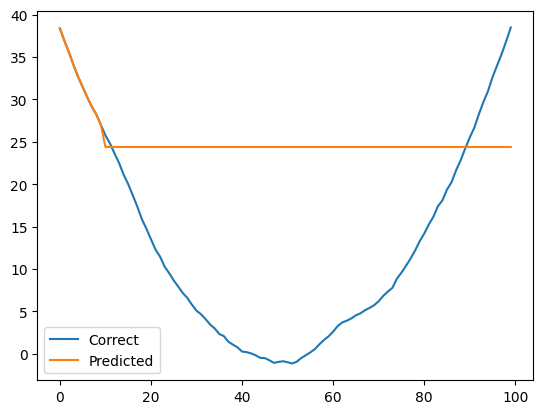

Epoch:951/1000 Error:788.1574615562657


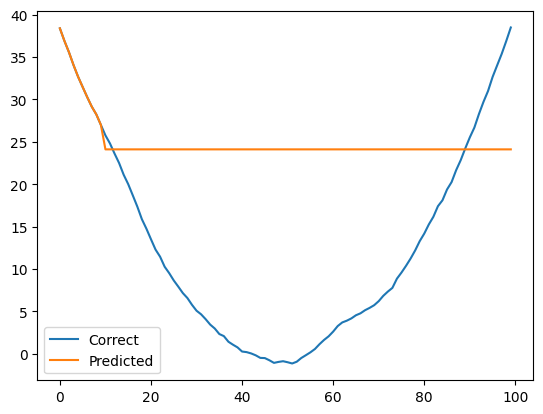

Epoch:956/1000 Error:1132.6852059997213


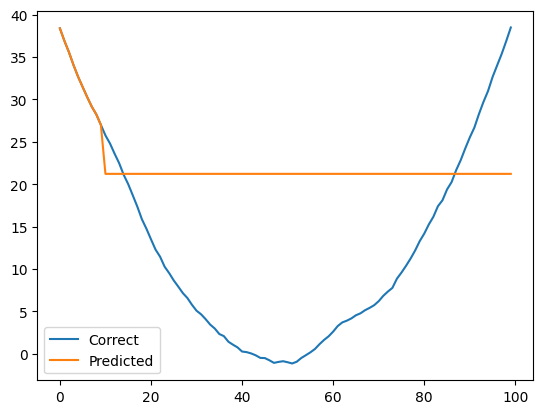

Epoch:961/1000 Error:1058.4420010546173


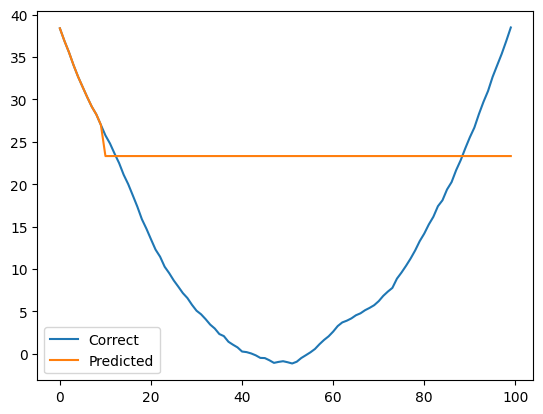

Epoch:966/1000 Error:886.3192866828099


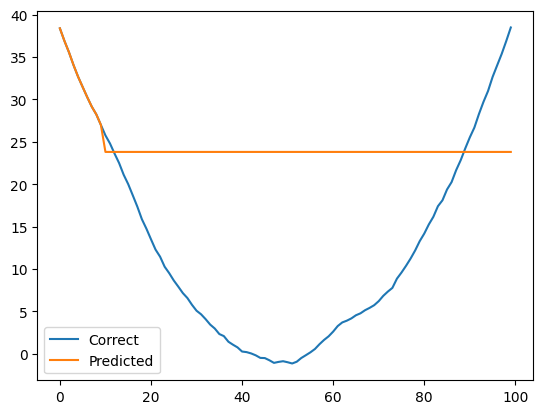

Epoch:971/1000 Error:2115.033556231519


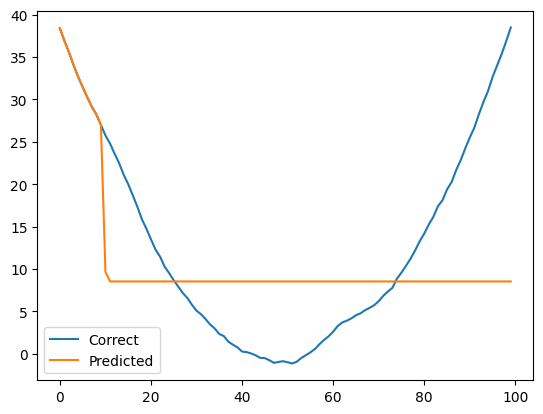

Epoch:976/1000 Error:963.0664578773833


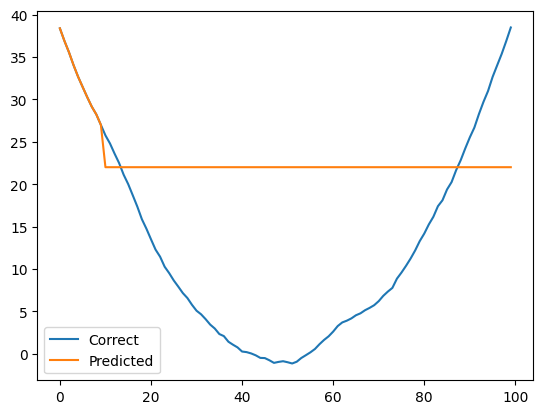

Epoch:981/1000 Error:883.3345074732237


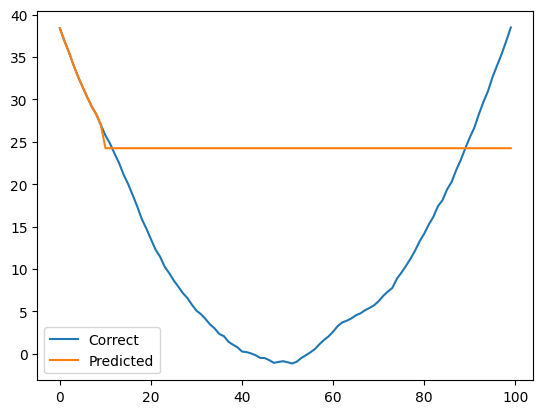

Epoch:986/1000 Error:925.5415787330015


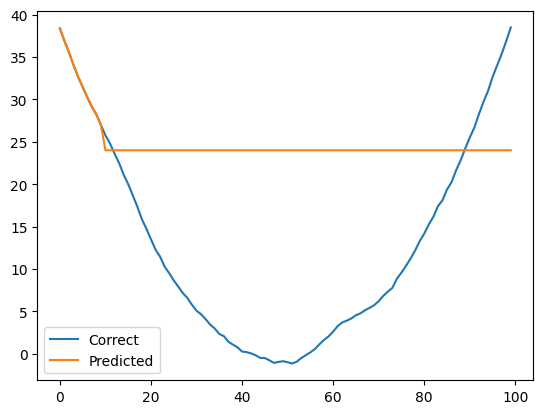

Epoch:991/1000 Error:934.0292371509054


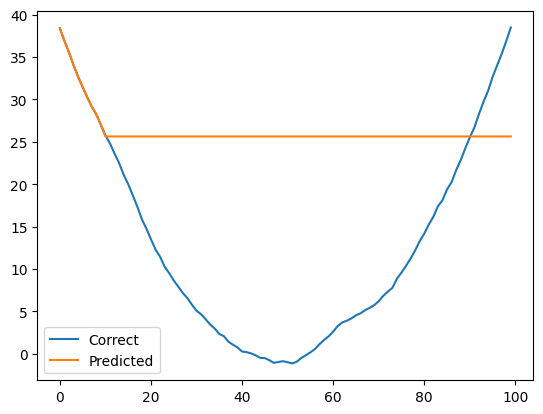

Epoch:996/1000 Error:847.578885224906


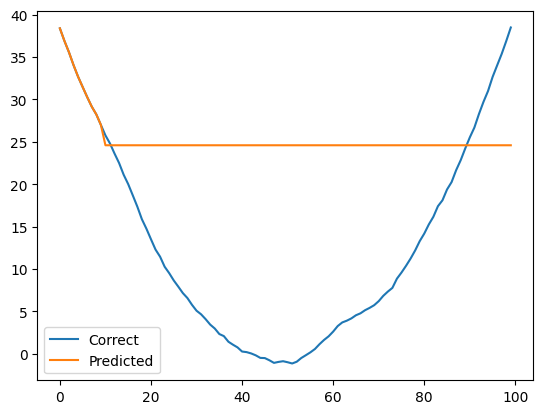

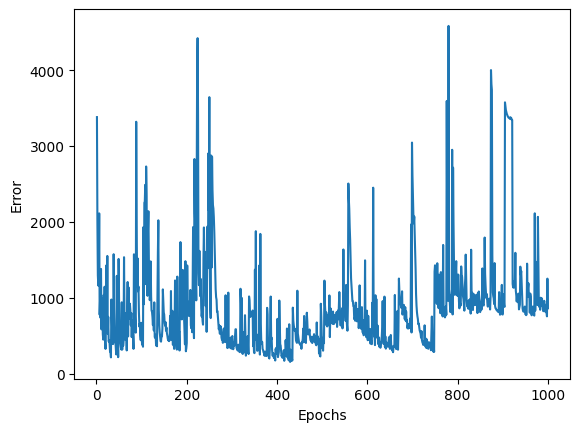

In [20]:
error_record = []
n_batch = len(input_data) // batch_size  # 每个epoch的批次数量

for i in range(epochs):
        
    # -- 学习 -- 
    index_random = np.arange(len(input_data))
    np.random.shuffle(index_random)  # 将索引打乱
    for j in range(n_batch):
        
        # 取出小批次数据进行训练
        mb_index = index_random[j*batch_size : (j+1)*batch_size]
        x_mb = input_data[mb_index, :]
        t_mb = correct_data[mb_index, :]
        train(x_mb, t_mb)

    # -- 计算误差 --
    error = get_error(input_data, correct_data)
    error_record.append(error)

    # -- 显示处理进度 -- 
    if i%interval == 0:
        print("Epoch:"+str(i+1)+"/"+str(epochs), "Error:"+str(error))

        predicted = input_data[0].reshape(-1).tolist() # 起始的输入
        for i in range(n_sample):
            x = np.array(predicted[-n_time:]).reshape(1, n_time, 1)
            y = predict(x)
            predicted.append(float(y[0, 0]))  # 将输出添加到predicted中

        plt.plot(range(len(sin_y)), sin_y.tolist(), label="Correct")
        plt.plot(range(len(predicted)), predicted, label="Predicted")
        plt.legend()
        plt.show()

plt.plot(range(1, len(error_record)+1), error_record)
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

In [21]:
arr3 = np.zeros((3, 6))

In [22]:
print(arr3)

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


In [23]:
arr3.reshape(-1,1)

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [24]:
index_random = np.arange(len(input_data))
print(index_random)
np.random.shuffle(index_random)  # 将索引打乱
print(index_random)

for j in range(1):
        
        # 取出小批次数据进行训练
    mb_index = index_random[j*batch_size : (j+1)*batch_size]
    x_mb = input_data[mb_index, :]
    print(x_mb)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89]
[32 63 59 86 11 38  7 58  8 22 25 79 60  5 14 42 13 12  3 65 50 45  0 67
 40 52 88 80 49 61 29 27 23  9 70 85 66 36 28 43 87 62 76 48  2 54 77 84
 47 24 34 74 41 31 33 10 20 82 75  1 81  4 55 17 16 71 83 30 21 18 15  6
 19 39 35 68 89 46 56 57 64 37 69 26 44 53 72 78 51 73]
[[[ 4.07700737]
  [ 3.43861675]
  [ 2.97763747]
  [ 2.32763426]
  [ 2.07951255]
  [ 1.41633133]
  [ 1.06668992]
  [ 0.74866967]
  [ 0.26022625]
  [ 0.19141588]]

 [[ 3.90132376]
  [ 4.17058176]
  [ 4.53954546]
  [ 4.77062004]
  [ 5.13449528]
  [ 5.40969382]
  [ 5.72701243]
  [ 6.20325291]
  [ 6.82946801]
  [ 7.32912463]]

 [[ 2.05582938]
  [ 2.61363561]
  [ 3.26784703]
  [ 3.69482992]
  [ 3.90132376]
  [ 4.17058176]
  [ 4.53954546]
  [ 4.77062004